# **Reconnaissance d'euros en espèces de banque (Finance / Banque)**

#**1. Définition du problème**

*Nom du projet* : Détection et classification de pièces en euros (1c, 2c, 10c, 20c, 50c, 1€, 2€)


---



**Objectif principal**

Construire un système de vision par ordinateur capable de détecter, et classer les pièces en euros présentes dans une image en distinguant les classes :

*  1c
*  2c
*  10c
*  20c
*  50c
*  1e
*  2e

---

**Entrées / Sorties**

**Entrée** : image RGB prise par une caméra standard.

**Sortie** : pour chaque pièce détectée → {classe, confidence}.

#**2. Préparation des données**
*  **2.1 Collecte**
*  **2.2 Organisation des données**
*  **2.3 Exploration**
*  **2.4 Pré-traitement**






 ## **2.1 Collecte** : récupérer le dataset (Google Drive).

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chemins des répertoires contenant les images
train_dir = '/content/drive/My Drive/Datasets Google Colab/coins-dataset/train'
test_dir = '/content/drive/My Drive/Datasets Google Colab/coins-dataset/test'
prod_dir = '/content/drive/My Drive/Datasets Google Colab/coins-dataset/test'

In [ ]:

# Dossier où les modèles sont sauvegardés
save_dir = "/content/drive/MyDrive/saved_models/detection_euro"

In [ ]:
os.makedirs("/content/drive/My Drive/saved_models/detection_euro", exist_ok=True)



In [ ]:
!pip install optuna

In [ ]:
!pip install mlflow

In [ ]:
#Importations des librairies
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tensorflow as tf
import random
import gc
import mlflow
import mlflow.tensorflow
import optuna
from keras import optimizers
from keras.models import load_model
from tensorflow.keras import models, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
import pandas as pd
from PIL import Image
import os

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
#Lister des repertoires dans les répertoires d'entrainement
noms_fichiers_train = os.listdir(train_dir)
print(noms_fichiers_train)


['2e', '5c', '1c', '20c', '10c', '1e', '50c', '2c']


In [ ]:
#Lister des repertoires dans les répertoires de test
noms_fichiers_test = os.listdir(test_dir)
print(noms_fichiers_test)

['5c', '20c', '2c', '1e', '1c', '50c', '2e', '10c']


## **2.2 Organisation des données**

---


*  **2.2.1** Préparation des labels	Encoder les classes en entiers avec LabelEncoder

---


*  **2.2.2** Mapping des fichiers	Associer chaque image à son label encodé et stocker dans un DataFrame

---


*  **2.2.3** Dataset final	DataFrame complet prêt pour l’entraînement du modèle

### **2.2.1** Préparation des labels	Encoder les classes en entiers avec LabelEncoder

Pour entraîner un modèle de classification multiclasse, il est courant que la colonne cible (labels) soit encodée sous forme d’entiers



In [ ]:
# Liste de labels (noms des sous-dossiers)
labels = ["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"]

# Encoder les labels en entiers
encoder_target = LabelEncoder()
encoded_labels = encoder_target.fit_transform(labels)

#affichage du codage associé
for label,code in zip(labels,encoded_labels):
  print(label,code)

1c 1
2c 4
5c 7
10c 0
20c 3
50c 6
1e 2
2e 5


 ### **2.2.2** Mapping des fichiers	Associer chaque image à son label encodé et stocker dans un DataFrame

In [ ]:
# Créer un DataFrame vide pour stocker toutes les images
df_train = pd.DataFrame(columns=['filename', 'labels'])

# Boucle sur les labels et leurs codes encodés
for label, code in zip(labels, encoded_labels):
    folder_path = os.path.join(train_dir, label)
    images = os.listdir(folder_path)
    print(f"Il y a {len(images)} images pour la classe {label}")

    # Ajouter le chemin relatif dans filename : "classe/nom_fichier"
    file_paths = [os.path.join(label, img) for img in images]

    # Créer le DataFrame pour cette classe
    df_label = pd.DataFrame({
        'filename': file_paths,
        'labels': code
    })

    # Concaténer avec le DataFrame principal
    df_train = pd.concat([df_train, df_label], ignore_index=True)


### **2.2.3** Dataset final	DataFrame complet prêt pour l’entraînement du modèle

In [ ]:
# Nombre d'images
print(f"Total images : {len(df_train)}")
print(df_train.head())

Il y a 77 images pour la classe 1c
Il y a 25 images pour la classe 2c
Il y a 284 images pour la classe 5c
Il y a 254 images pour la classe 10c
Il y a 227 images pour la classe 20c
Il y a 131 images pour la classe 50c
Il y a 248 images pour la classe 1e
Il y a 45 images pour la classe 2e
Total images : 1291
             filename labels
0  1c/train_21_44.jpg      1
1   1c/train_13_9.jpg      1
2  1c/train_20_58.jpg      1
3  1c/train_12_28.jpg      1
4  1c/train_13_26.jpg      1


## **2.3 Exploration**


*   **2.3.1** Visualiser quelques exemples
*   **2.3.2** Vérifier le déséquilibre des classes
*   **2.3.3** Vérifier la qualité et la cohérence



### **2.3.1 Visualiser quelques exemples**

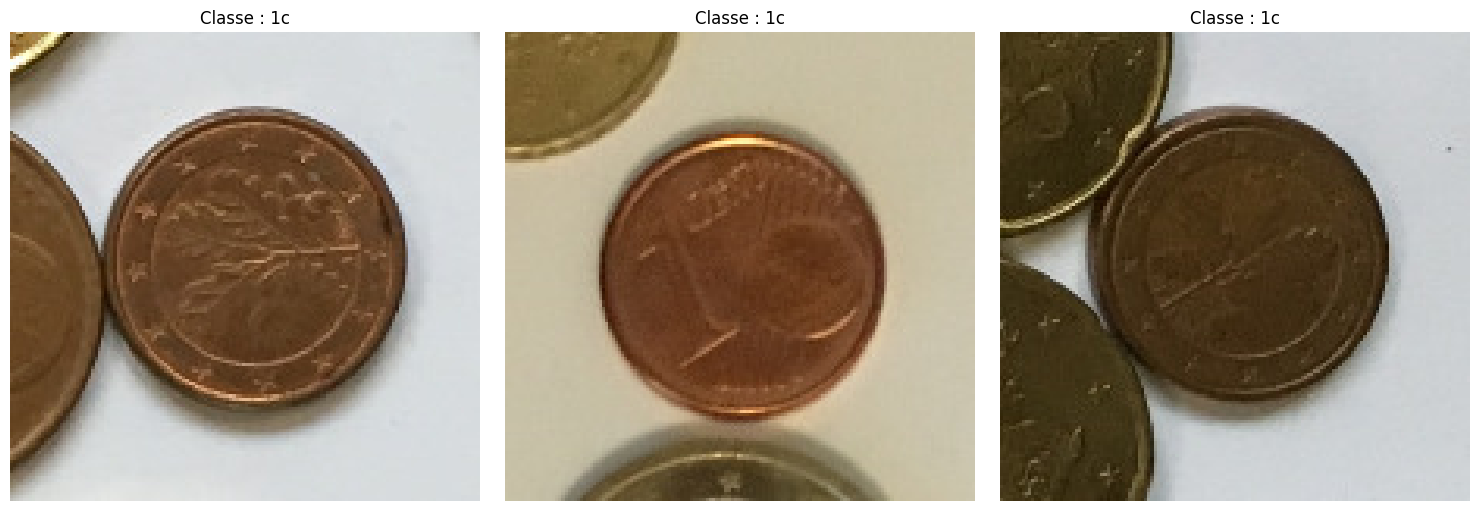

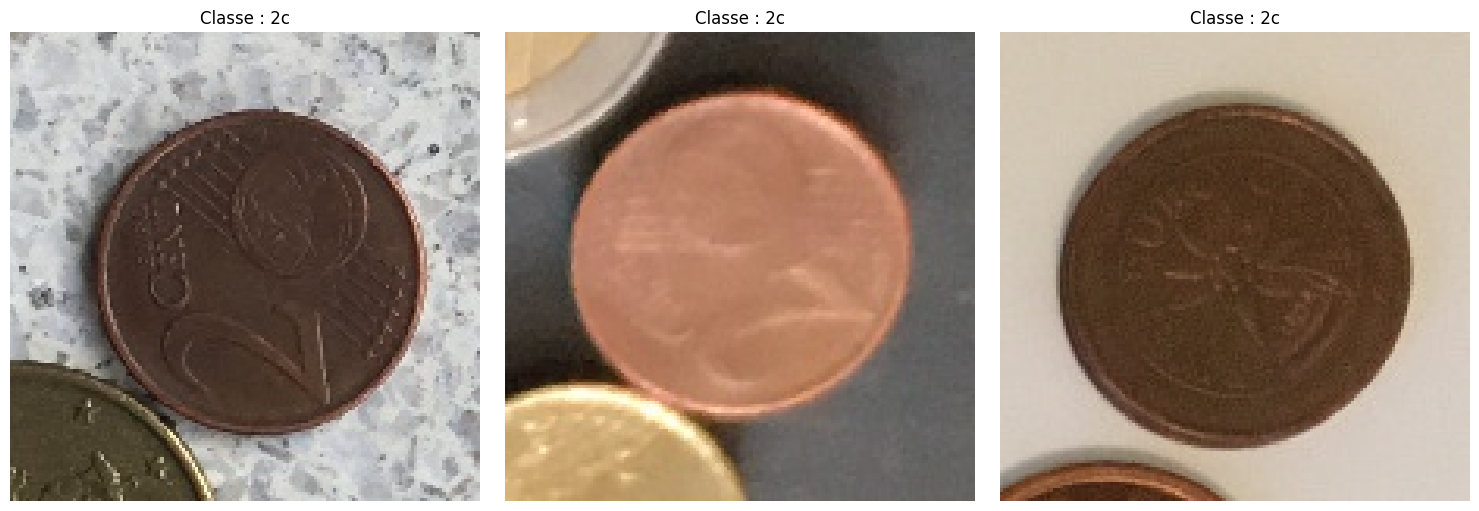

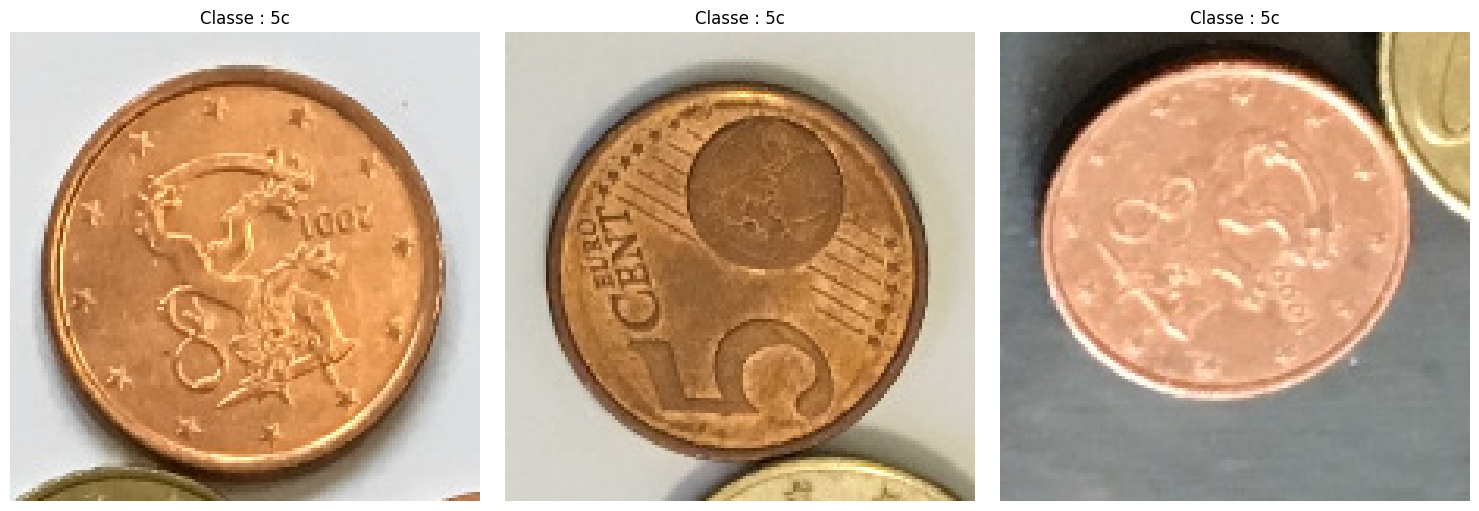

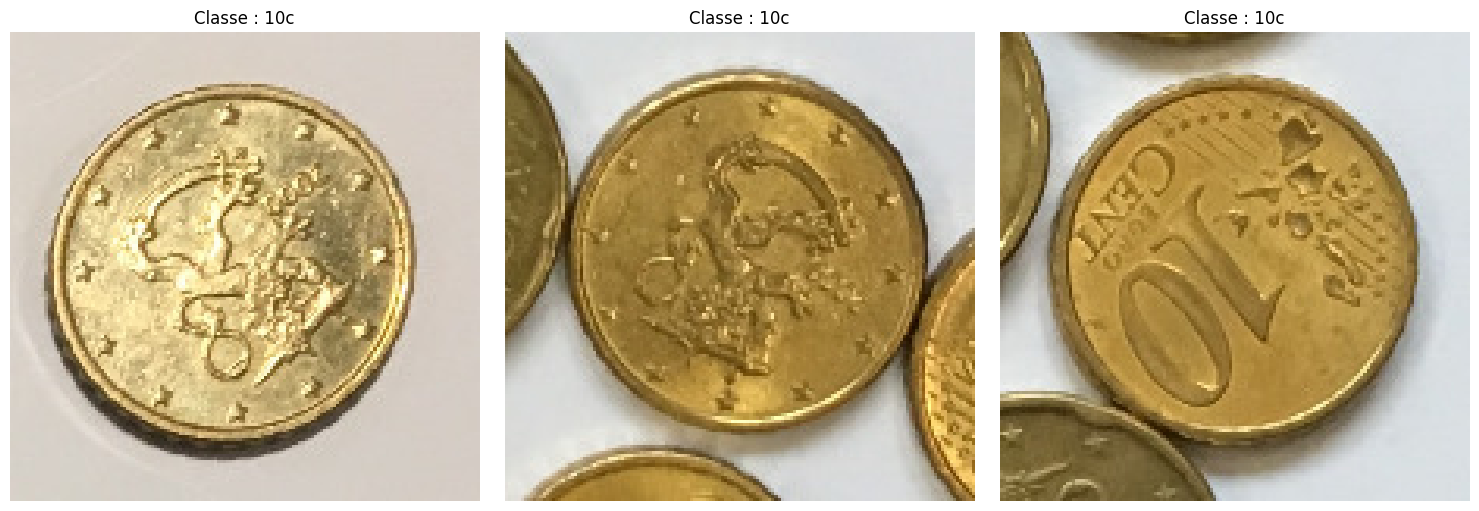

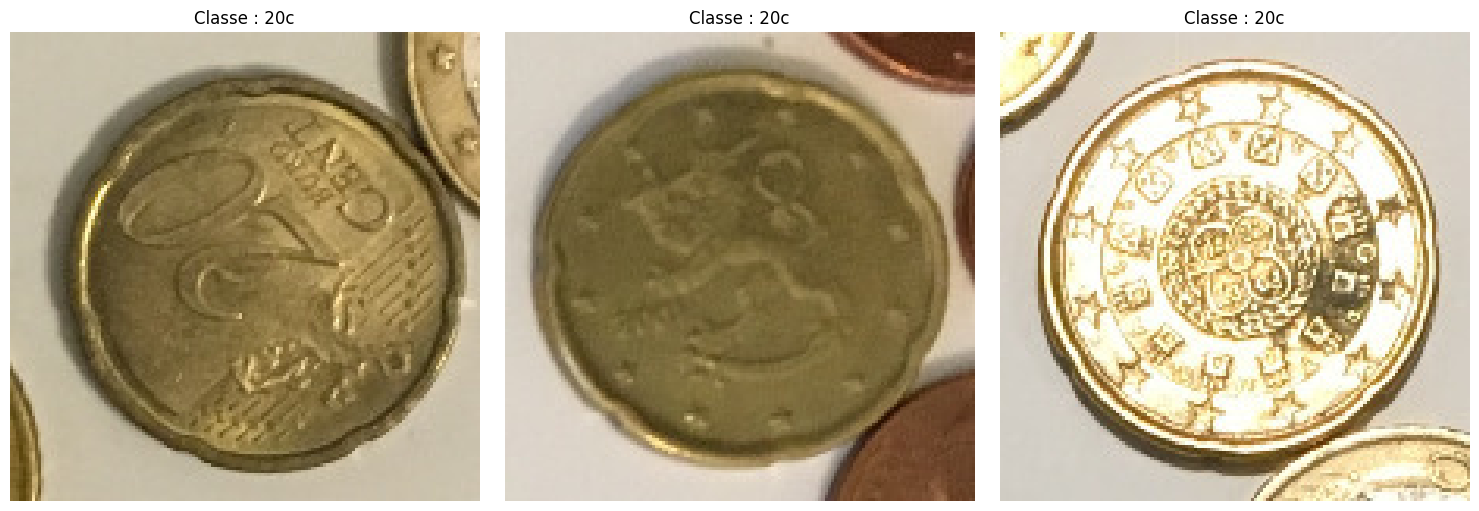

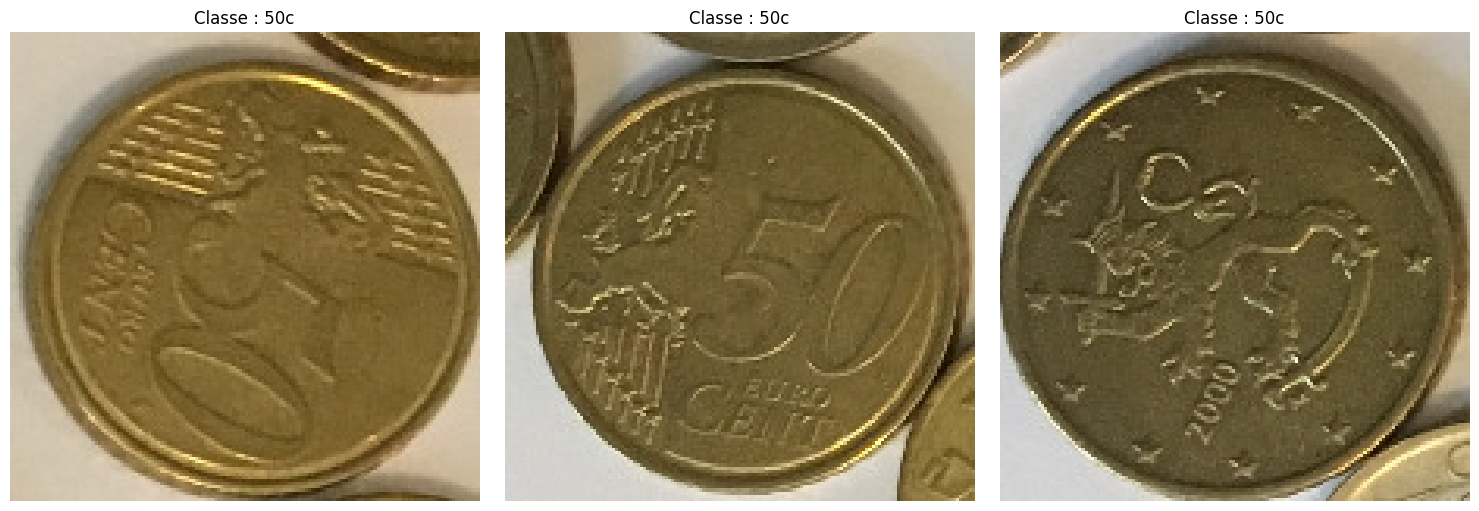

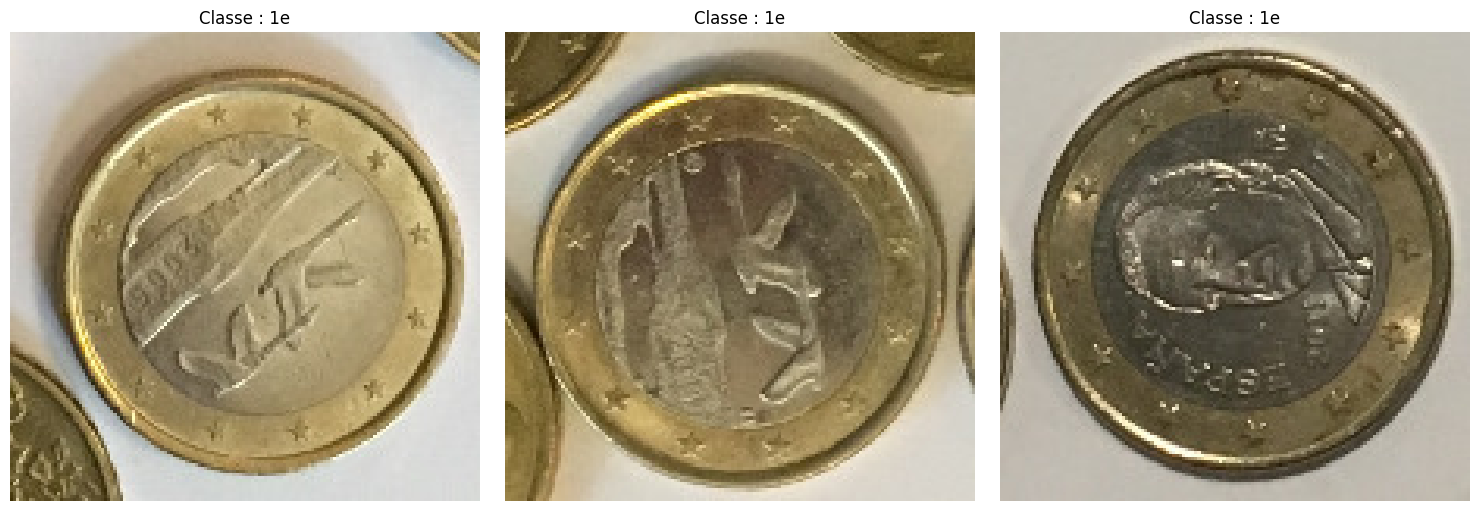

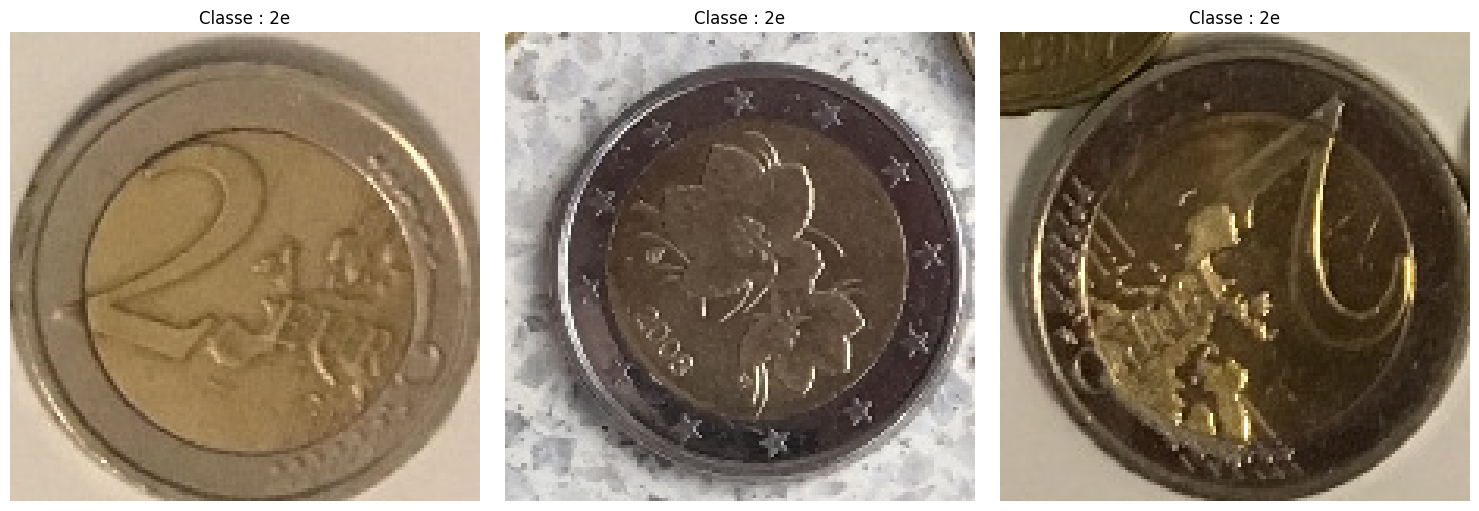

In [ ]:
# Paramètres
n_images = 3  # nombre d'images à afficher par classe
n_cols = 3    # nombre de colonnes dans la grille

for label in labels:
    folder_path = os.path.join(train_dir, label)
    images = os.listdir(folder_path)[:n_images]  # prendre les n_images premières

    # Créer la figure et les sous-graphes
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].set_title(f"Classe : {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


### **2.3.2 Vérifier le déséquilibre des classes**

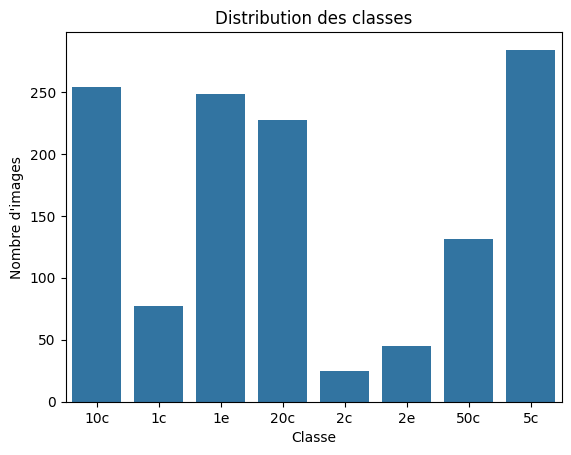

In [ ]:
# Créer un mapping int → nom de classe
label_mapping = dict(zip(encoder_target.transform(labels), labels))

# Compter le nombre d'images par label encodé
class_counts = df_train['labels'].value_counts().sort_index()

# Remplacer les codes par les noms de classes
class_names = [label_mapping[i] for i in class_counts.index]

# Plot
sns.barplot(x=class_names, y=class_counts.values)
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes")
plt.show()


### **2.3.3 Vérifier la qualité et la cohérence**

Essayons d’ouvrir chaque image avec PIL et Si une image est corrompue, elle déclenche une exception.

In [ ]:
corrupted_images = []

for label in labels:
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()  # vérifie si l'image est lisible
        except (IOError, SyntaxError) as e:
            corrupted_images.append(img_path)

print(f"Images corrompues : {corrupted_images}")


Images corrompues : []


Les images doivent avoir la même taille ou être redimensionnées avant l’entraînement, on va donc lister toutes les dimensions pour vérifier la cohérence

In [ ]:
sizes = []

for label in labels:
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        sizes.append(img.size)  # (largeur, hauteur)

# Afficher les dimensions uniques
print(set(sizes))


{(150, 150)}


Les modèles CNN attendent généralement des images RGB (3 canaux)

In [ ]:
modes = []

for label in labels:
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        modes.append(img.mode)

print(set(modes))


{'RGB'}


In [ ]:
df_train.tail()

filename labels
1286   2e/train_17_8.jpg      5
1287   2e/train_15_6.jpg      5
1288    2e/train_4_0.jpg      5
1289  2e/train_31_12.jpg      5
1290   2e/train_15_5.jpg      5

## **2.4. Pré-traitement des données pour la génération d'images**

**1. Décoder le contenu JPG en grilles de pixels RGB.**

  Une fois que les images sont lues, nous devons les décoder à partir de leur format JPG compressé en grilles de pixels RGB (Rouge, Vert, Bleu). Cela transforme l'image en une matrice de valeurs numériques représentant les couleurs.

**2. Convertir ces grilles en tableaux de nombres à virgule flottante.**

Les réseaux de neurones travaillent mieux avec des nombres. Nous devons donc convertir les grilles de pixels en tableaux de nombres à virgule flottante pour pouvoir les utiliser dans nos modèles de deep learning.

**3. Rescaler les valeurs des pixels entre 0 et 255 à l'intervalle 0,1.**

Les réseaux de neurones préfèrent traiter des valeurs d'entrée petites et normalisées. Nous devons donc rescaler les valeurs des pixels de leur intervalle original [0, 255] à l'intervalle [0, 1].


*Cette étape de normalisation permet d'améliorer la performance et la stabilité du modèle d'apprentissage, en garantissant que les valeurs d'entrée sont petites et homogènes.*


In [ ]:
def affiche_image_aléatoire():
  random_path = random.choice(os.listdir(train_dir)) #nom repertoire aléatoire
  folder_path= os.path.join(train_dir,random_path) #chemin du répertoire aléatoire
  random_img = random.choice(os.listdir(folder_path)) #nom image aléatoire
  img_path = os.path.join(train_dir,folder_path,random_img) #chemin de l'image aléatoire
  img = image.load_img(img_path)
  plt.title(random_img)
  plt.imshow(img)
  plt.show()

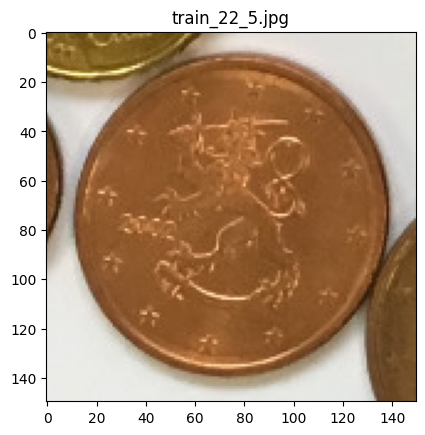

In [ ]:
affiche_image_aléatoire()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Ré-échelle les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
    #validation_split=0.2  # 20% des données pour la validation
)


In [ ]:
# S'assurer que la colonne 'labels' contient des chaînes de caractères car class_mode='sparse' attend des strings, pas des entiers.
df_train['labels'] = df_train['labels'].astype(str)

In [ ]:
df_train.shape

(1291, 2)

In [ ]:
# Split stratifié pour que chaque classe soit représentée dans train et val car notre dataframe a les classes groupé l'une après l'autre
df_train_split, df_val_split = train_test_split(
    df_train,
    test_size=0.2,      # 20% pour validation
    stratify=df_train['labels'],
    random_state=42
)

In [ ]:
df_train_split.shape

(1032, 2)

In [ ]:
df_val_split.shape

(259, 2)

In [ ]:


# Génerateur pour les données d'entrainnement
train_generator = train_datagen.flow_from_dataframe(
    df_train_split,
    train_dir,
    x_col='filename',
    y_col='labels',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    #subset='training',  # Utiliser les données d'entrainnement
    shuffle=True
)


Found 1032 validated image filenames belonging to 8 classes.


In [ ]:
# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_dataframe(
    df_val_split,
    train_dir,
    x_col='filename',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    #subset='validation', # Utiliser les données de validation
    shuffle =False
)


Found 259 validated image filenames belonging to 8 classes.


Taille du lot de données : (32, 150, 150, 3)
Taille du lot d'étiquettes : (32, 8)


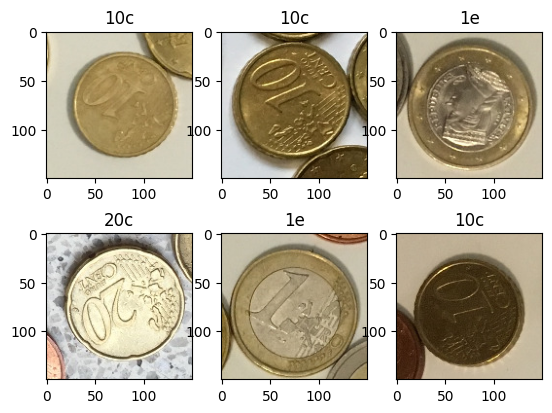

In [ ]:
int_to_class = {
    0: "10c",
    1: "1c",
    2: "1e",
    3: "20c",
    4: "2c",
    5: "2e",
    6: "50c",
    7: "5c"
}

# Affichage de quelques images pour vérifier le prétraitement
for data_batch, labels_batch in train_generator:
    print("Taille du lot de données :", data_batch.shape)  # Affiche la forme du lot de données
    print("Taille du lot d'étiquettes :", labels_batch.shape)  # Affiche la forme du lot d'étiquettes
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(data_batch[i])  # Affiche l'image prétraitée
        # Find the index of the maximum value in the one-hot encoded label
        class_index = np.argmax(labels_batch[i])
        plt.title(int_to_class[class_index])  # Titre en fonction de l'étiquette
    plt.show()
    break  # Affiche un seul lot d'images

#**3. Modélisation**
## **3.1. Introduction à la modélisation**

L’objectif de cette section est de tester plusieurs approches de modélisation afin d’identifier celle offrant la meilleure performance de classification. Cinq modèles ont été construits et comparés :
* un CNN simple
* un CNN optimisé,
* trois modèles basés sur VGG16 (feature extraction et fine-tuning).


| Modèle | Type                     | Data Augmentation | Régularisation | Optimisation | Normalisation | Fine-Tuning | Callbacks |
| :----- | :----------------------- | :---------------- | :------------- | :----------- | :------------ | :---------- | :-------- |
| 1      | CNN simple               | ❌                 | ❌              | Manuel       | ❌             | ❌           | ❌         |
| 2      | CNN optimisé             | ✅                 | ✅              | Optuna       | ✅             | ❌           | ✅         |
| 3      | VGG16 Feature Extraction | ❌                 | ✅              | Optuna       | ✅             | ❌           | ✅         |
| 4      | VGG16 Feature Extraction | ✅                 | ✅              | Optuna       | ✅             | ❌           | ✅         |
| 5      | VGG16 Fine-Tuning        | ✅                 | ✅              | Optuna       | ✅             | ✅           | ✅         |


### **3.2. Modèle 1 : CNN de base**

**a. Choix du modèle :**
Un réseau de neurones convolutif simple (CNN) a été implémenté comme point de départ.

**b. Architecture :**

Couches convolutionnelles + pooling + fully connected

Activations : ReLU (couches cachées) et Softmax (sortie)

**c. Hyperparamètres :**

* Learning rate

* Batch size

* Nombre d’époques

* Optimiseur : Adam / SGD / RMSprop

* Fonction de perte : categorical cross-entropy

**d. Objectif :**
Établir une performance de référence (baseline) pour comparaison.

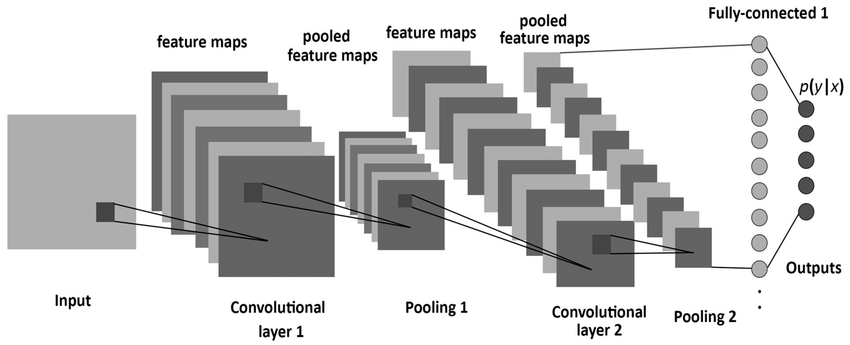

In [ ]:

model = models.Sequential()


model.add(layers.Input(shape=(150, 150, 3))),

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))  # Couche de convolution : 32 filtres de 3x3, détecte des motifs simples dans l'image, ReLU pour rendre le modèle non-linéaire, forme d'entrée (150x150x3).

model.add(layers.MaxPooling2D((2, 2)))  # Couche de max pooling : réduit les dimensions de l'image en prenant le maximum de chaque carré de 2x2 pixels.

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Deuxième couche de convolution : 64 filtres de 3x3, détecte des motifs plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Deuxième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Troisième couche de convolution : 128 filtres de 3x3, détecte des motifs encore plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Troisième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Flatten())  # Couche Flatten : transforme les données 2D en un vecteur 1D pour la couche dense suivante.

model.add(layers.Dense(512, activation='relu'))  # Couche dense (fully connected) : 512 neurones, chaque neurone est connecté à tous les neurones de la couche précédente, ReLU pour l'activation.

model.add(layers.Dense(8, activation='softmax'))  # Couche de sortie : 8 neurone, activation softmax utilisée pour la classification multiclasse.


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **4. Entraînement modèle 1**

Avant l'entrainement assurons nous que tous nos classes sont bien représentées dans les données d'entraînement et de validation.

In [ ]:

# Vérification du nombre d'images par classe dans le train et la validation
train_counts = np.bincount(train_generator.classes)
val_counts = np.bincount(validation_generator.classes)

class_labels = list(train_generator.class_indices.keys())

print("\nRépartition des classes dans le TRAINING set :")
for label, count in zip(class_labels, train_counts):
    print(f"{label}: {count} images")

print("\nRépartition des classes dans le VALIDATION set :")
for label, count in zip(class_labels, val_counts):
    print(f"{label}: {count} images")

# Visualisation rapide
plt.figure(figsize=(10,4))
plt.bar(class_labels, train_counts, alpha=0.6, label='Train')
plt.bar(class_labels, val_counts, alpha=0.6, label='Validation')
plt.legend()
plt.title("Répartition des classes avant l'entraînement")
plt.show()


In [ ]:
# Entraînement du modèle et sauvegarde de l'historique d'entraînement dans 'history'

start_time = time.time()

history = model.fit(
    train_generator,  # Utilise le générateur pour les données d'entraînement

    # Le nombre d'étapes (batches) à exécuter à chaque époque.
    # Calculé comme le nombre total d'échantillons d'entraînement divisé par la taille du lot.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,

    epochs=30,  # Nombre total d'époques pour l'entraînement

    validation_data=validation_generator,  # Utilise le générateur pour les données de validation

    # Le nombre d'étapes (batches) à exécuter pour chaque époque de validation.
    # Calculé comme le nombre total d'échantillons de validation divisé par la taille du lot.
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
end_time = time.time()

# **5. Analyse des métriques et courbes clés — Modèle 1**
* **5.1. Analyse des courbes d’apprentissage**

  * Méthode visuelle :
    Présentation et interprétation des courbes de loss et accuracy sur les ensembles d’entraînement et de validation.

  * Méthode quantitative :
    Calcul des écarts entre les performances train/validation pour détecter surapprentissage ou sous-apprentissage.

* **5.2. Rapport de classification**

   * Présentation des métriques principales : précision, rappel, F1-score, support.

   * Analyse des classes les mieux et les moins bien prédites.

* **5.3. Prédictions sur la base de validation**

    * Génération des prédictions finales sur les données de validation.

    * Comparaison entre labels réels et labels prédits.

* **5.4. Matrice de confusion**

    * Visualisation de la répartition des prédictions correctes et incorrectes.

    * Interprétation des classes les plus confondues.

* **5.5. Temps d’entraînement**

  * Durée totale de l’apprentissage.





## **5.1. Analyse des courbes d’apprentissage**


### **5.1.1 Méthode visuelle**
*   **Cas 1 :** les deux courbes (train et val) montent et se stabilisent haut
    
    Bon signe : le modèle apprend bien et généralise.

*   **Cas 2 :** train ↑ et val ↓ après quelques époques

    **Surapprentissage (overfitting)** → Le modèle mémorise au lieu de généraliser.

    **Actions possibles** :

    * Ajouter du dropout

    * Augmenter la data augmentation

    * Réduire le nombre d’époques

    * Ajouter de la régularisation L2

*  **Cas 3 :** train et val restent faibles

    **Sous-apprentissage (underfitting)** → Le modèle ne parvient pas à apprendre.
    
    **Actions possibles :**

    * Entraîner plus longtemps

    * Modifier l’architecture (plus de couches)

    * Augmenter le learning rate légèrement

*  **Cas 4 :** validation instable

    * Trop de bruit → Learning rate trop haut ou data trop variée.

In [ ]:

# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

### **5.1.2 Méthode quantitative**

**Écart	Niveau de surapprentissage**
* **< 0.02** :	Faible
* **0.02 – 0.05** :	Modéré
* **> 0.05**	: Fort

In [ ]:
train_acc = np.mean(history.history['accuracy'][-5:])
val_acc = np.mean(history.history['val_accuracy'][-5:])
overfitting_gap = train_acc - val_acc

print(f"Train acc (moyenne 5 dernières époques): {train_acc:.3f}")
print(f"Val acc (moyenne 5 dernières époques): {val_acc:.3f}")
print(f"Écart de surapprentissage : {overfitting_gap:.3f}")


## **5.2. Rapport de classification**

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prédictions sur validation
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

print(classification_report(y_true, y_pred_classes))


## **5.3. Prédictions sur la base de validation**

In [ ]:
# Évaluer les performances du modèle sur la base de validation
validation_steps = validation_generator.samples // validation_generator.batch_size
evaluation = model.evaluate(validation_generator, steps=validation_steps)

# Afficher les résultats de l'évaluation
print(f"Perte sur la validation: {evaluation[0]}")
print(f"Précision sur la validation: {evaluation[1]}")

In [ ]:
# Étapes de validation (comme dans ton fit)
validation_steps = validation_generator.samples // validation_generator.batch_size

# Prédire les classes de la validation
Y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred = np.argmax(Y_pred, axis=1)

# Récupérer les vraies classes
y_true = validation_generator.classes

# Noms des classes
class_labels = list(validation_generator.class_indices.keys())


## **5.4. Matrice de confusion**

In [ ]:
cm1 = confusion_matrix(y_true[:len(y_pred)], y_pred)


**Afficher joliment la matrice avec Seaborn**

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion - Détection de pièces en euros')
plt.show()


## **5.5. Temps d'entrainement**

In [ ]:
training_time = end_time - start_time
print(f"⏱️ Temps total d'entraînement du modèle 1 : {training_time/60:.2f} minutes")

#**6. Optimisation**
   - Régularisation : Dropout
   - Data augmentation
   - Optimisation des hyperparamètres avec Optuna
   - Normalisation : Batch Normalization
   - Callbacks : EarlyStopping, ReduceLROnPlateau


* **Régularisation (Dropout)**

    **But** :
    * régulariser le modèle pour éviter le surapprentissage.

  ---

* **La Batch Normalization**

    **But** :
    * stabiliser la distribution des activations dans le réseau,
    * accélérer la convergence,
    * réduire le surapprentissage.

  ---

* **Optuna : l’optimisation bayésienne intelligente**

    **Optuna** est une optimisation adaptative et intelligente :
    il observe les résultats précédents pour prédire quelles zones de l’espace des hyperparamètres valent la peine d’être explorées.

    Dans notre cas, on va s'intéresser aux hyperparamètres :
    learning rate
    
    * **learning rate**

    * **dropout rate**

    * **nombre de filtres**

    * **taille des couches denses**

    * **optimiseur**

In [ ]:
# # Supprimer tous les anciens modèles s’il y en a
# old_models = glob.glob(os.path.join(save_dir, "best_model2_trial_*.keras"))

# if old_models:
#     print(f"Suppression de {len(old_models)} anciens modèles...")
#     for model_path in old_models:
#         os.remove(model_path)
#         print(f"Supprimé : {model_path}")
# else:
#     print("Aucun ancien modèle à supprimer.")

##**6.1. Modèle 2 : CNN optimisé (avec Optuna)**

**a. Améliorations apportées :**

* Régularisation : Dropout

* Normalisation : Batch Normalization

* Data augmentation

* Optimisation automatique des hyperparamètres avec Optuna

* Callbacks : EarlyStopping, ReduceLROnPlateau

**b. Objectif :**
Améliorer la robustesse et la généralisation du modèle CNN de base.

### **6.1.1 Fonction d'entraînement Optuna Modèle 2** texte en gras

In [ ]:
# Fonction d'entraînement Optuna
def objective(trial):
    # Hyperparamètres à tester
    #lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    dense_units = trial.suggest_categorical('dense_units', [256, 512, 1024])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    conv1_filters = trial.suggest_categorical('conv1_filters', [32, 64])
    conv2_filters = trial.suggest_categorical('conv2_filters', [64, 128])
    conv3_filters = trial.suggest_categorical('conv3_filters', [128, 256])
    rotation = trial.suggest_int('rotation_range', 0, 30)
    zoom = trial.suggest_float('zoom_range', 0.0, 0.3)

    # Nettoyage mémoire
    tf.keras.backend.clear_session()
    import gc
    gc.collect()

    # Modèle CNN
    model2 = models.Sequential([
        layers.Input(shape=(150, 150, 3)),

        layers.Conv2D(conv1_filters, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(conv2_filters, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(conv3_filters, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(dropout_rate),

        layers.Flatten(),

        layers.Dense(dense_units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='softmax')
    ])

    # Compilation du modèle
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model2.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Générateurs de données
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range= rotation,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range= zoom,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        df_train_split,
        train_dir,
        x_col='filename',
        y_col='labels',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_dataframe(
        df_val_split,
        train_dir,
        x_col='filename',
        y_col='labels',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    )

    checkpoint_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model2_trial_{trial.number}.keras"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )
    # Entraînement
    start_time = time.time()
    history = model2.fit(
      train_generator,
      epochs=25,
      validation_data=validation_generator,
      callbacks=[early_stop, reduce_lr, model_checkpoint],
      verbose=0
    )

    end_time = time.time()

    #Stocker l'historique dans le trial pour pouvoir le récupérer après
    trial.set_user_attr("history", history.history)

    trial.set_user_attr("training_time", end_time - start_time)

    val_acc = max(history.history['val_accuracy'])
    print(f"Trial done: val_acc={val_acc:.4f}, time={end_time - start_time:.1f}s")
    return val_acc


# Lancement de l'étude Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study.optimize(objective, n_trials=30)


# Résultats
print("Meilleurs hyperparamètres : ")
print(study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


In [ ]:
# Numéro du meilleur trial
best_trial_number = study.best_trial.number
print(f"Best trial number: {best_trial_number}")

# Lister tous les fichiers de model 2
all_models = glob.glob(os.path.join(save_dir, "best_model2_trial_*.keras"))

# Supprimer tous sauf le meilleur
for model_path in all_models:
    if f"best_model2_trial_{best_trial_number}.keras" not in model_path:
        os.remove(model_path)
        print(f"Supprimé : {model_path}")
    else:
        print(f"Conservé : {model_path}")


In [ ]:
#{'learning_rate': 0.009950198036054937, 'dropout_rate': 0.6526305648638174, 'dense_units': 256, 'optimizer': 'sgd', 'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 128, 'rotation_range': 3, 'zoom_range': 0.0722555794011562}
#Meilleure accuracy de validation : 0.9034749269485474

In [ ]:
best_time2 = study.best_trial.user_attrs["training_time"]
print(f"Temps d'entraînement du meilleur modèle : {best_time2:.2f} secondes")

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


### **6.1.2 Chargement du meilleur optuna modèle 2**


In [ ]:
best_model_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model2_trial_{best_trial_number}.keras"

# Charger le modèle complet
model2 = tf.keras.models.load_model(best_model_path)

# Récupérer l'historique du meilleur trial
history2 = study.best_trial.user_attrs["history"]


### **6.1.3. Analyse des métriques et courbes clés — Modèle 2**
* **6.1.3.1. Analyse des courbes d’apprentissage**

* **6.1.3.2. Rapport de classification**

   * Présentation des métriques principales : précision, rappel, F1-score, support.

   * Analyse des classes les mieux et les moins bien prédites.

* **6.1.3.3. Prédictions sur la base de validation**

    * Génération des prédictions finales sur les données de validation.

    * Comparaison entre labels réels et labels prédits.

* **6.1.3.4. Matrice de confusion**

    * Visualisation de la répartition des prédictions correctes et incorrectes.

    * Interprétation des classes les plus confondues.

* **6.1.3.5. Temps d’entraînement**

  * Durée totale de l’apprentissage.





#### **6.1.3.1. Analyse des courbes d’apprentissage**

In [ ]:
plt.figure(figsize=(15,8))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Model 1 Val Accuracy')
plt.plot(history2['accuracy'], label='Model 2 Train Accuracy')
plt.plot(history2['val_accuracy'], label='Model 2 Val Accuracy')
plt.title('Accuracy par epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Model 1 Train Loss')
plt.plot(history.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2['loss'], label='Model 2 Train Loss')
plt.plot(history2['val_loss'], label='Model 2 Val Loss')
plt.title('Loss par epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### **6.1.3.2. Rapport de classification**

In [ ]:

# Prédictions
y_pred_model2 = np.argmax(model2.predict(validation_generator), axis=1)

y_true = validation_generator.classes  # Labels réels

# Rapport de classification
print("Classification Report - Model 1:")
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

print("Classification Report - Model2:")
print(classification_report(y_true, y_pred_model2, target_names=validation_generator.class_indices.keys()))



#### **6.1.3.3. Prédictions sur la base de validation**

In [ ]:
# Modèle 1
print(f"Model 1 - Perte sur la validation: {evaluation[0]}")
print(f"Model 1 - Accuracy sur la validation: {evaluation[1]}")

#Modèle 2
val_loss2, val_acc2 = model2.evaluate(validation_generator, verbose=1)
print(f"Model 2 - Perte sur la validation: {val_loss2:.4f}")
print(f"Model 2 - Accuracy sur la validation: {val_acc2:.4f}")




#### **6.1.3.4. Matrice de confusion**

In [ ]:
# Matrices de confusion
cm2 = confusion_matrix(y_true, y_pred_model2)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Matrice de confusion - Modèle 1")
axes[0].set_xlabel("Prédictions")
axes[0].set_ylabel("Vérités")

sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Matrice de confusion - Modèle 2")
axes[1].set_xlabel("Prédictions")
axes[1].set_ylabel("Vérités")

plt.tight_layout()
plt.show()


#### **6.1.3.5 Temps d'execution**

In [ ]:
print(f" Temps total d'entraînement du modèle 1 : {training_time/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 2 : {best_time2/60:.2f} minutes")

#**Transfert Learning**
Utilisation de modèles pré-entrainés
* **1. Extraction de Caractéristiques (Feature Extraction)**

    **Étapes :**

    * Charger un modèle préentraîné sans la couche de classification finale.
    * Geler les poids des couches convolutives pour éviter de les entraîner à nouveau.
    * Ajouter une ou plusieurs couches de classification.
    * Entraîner uniquement les nouvelles couches de classification avec les nouvelles données.
* **2. Fine-Tuning**

    **Étapes :**

    * Charger un modèle préentraîné.
    * Débloquer certaines des dernières couches du modèle pour permettre leur réentraînement.
    * Ajouter des couches de classification si nécessaire.
    * Entraîner le modèle entier (ou les couches dégelées) avec les nouvelles données.

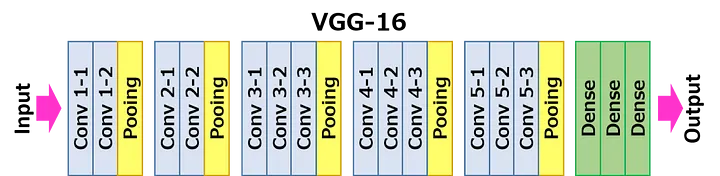


## **6.2 Modèle 3 : VGG16 (Feature Extraction sans Data Augmentation)**

**a. Approche :**

Utilisation d’un modèle pré-entraîné VGG16 sur ImageNet

Extraction des caractéristiques (feature extraction) sans entraînement des couches convolutives

**b. Paramètres :**

* Régularisation : Dropout

* Normalisation : Batch Normalization

* Optimisation des hyperparamètres : Optuna

* Callbacks : EarlyStopping, ReduceLROnPlateau

**c. Objectif :**
Évaluer la performance d’un modèle pré-entraîné sans data augmentation.

In [ ]:
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


### **6.2.1 Initialisation de la base convolutionnelle du modèle VGG16 préentraîné.**

In [ ]:

# weights='imagenet' signifie que le modèle est préentraîné sur l'ensemble de données ImageNet, qui contient des millions d'images annotées.
# include_top=False signifie que les couches de classification dense (top layers) ne sont pas incluses,
# ce qui permet d'utiliser le modèle comme un extracteur de caractéristiques sans la dernière couche de classification.
# input_shape=(150, 150, 3) définit la taille des images d'entrée attendues par le modèle (150x150 pixels avec 3 canaux pour RGB).
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data_gen = ImageDataGenerator(rescale=1.0/255)

### **6.2.2 Extraction des caractéristiques (feature extraction) sans entraînement des couches convolutives**

In [ ]:
batch_size=32

def extract_features(df, directory, sample_count):


    # Taille finale des features pour VGG16 avec input 150x150 : (4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, len(df['labels'].unique())))  # pour one-hot

    generator = data_gen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col='filename',
        y_col='labels',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important pour garder le même ordre
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [ ]:
# Appel de la fonction
train_features, train_labels = extract_features(df_train_split, train_dir, sample_count=len(df_train_split))
val_features, val_labels = extract_features(df_val_split, train_dir, sample_count=len(df_val_split))

In [ ]:
# # Supprimer tous les anciens modèles s’il y en a
# old_models = glob.glob(os.path.join(save_dir, "best_model3_trial_*.keras"))

# if old_models:
#     print(f"Suppression de {len(old_models)} anciens modèles...")
#     for model_path in old_models:
#         os.remove(model_path)
#         print(f"Supprimé : {model_path}")
# else:
#     print("Aucun ancien modèle à supprimer.")

### **6.2.3 Fonction d'entraînement Optuna Modèle 3**

In [ ]:

# Fonction d'entraînement Optuna pour le modèle basé sur des features extraites (model3)
def objective(trial):
    # Hyperparamètres à tester
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512, 1024])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Nettoyage mémoire
    tf.keras.backend.clear_session()
    gc.collect()

    # Modèle simple pour features extraites
    model3 = models.Sequential([
        layers.Flatten(input_shape=(4, 4, 512)),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(8, activation='softmax')  # 8 classes
    ])

    # Choix de l’optimiseur
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compilation
    model3.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    )
    checkpoint_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model3_trial_{trial.number}.keras"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    # Entraînement
    start_time = time.time()
    history = model3.fit(
        train_features, train_labels,
        epochs=30,
        batch_size=32,
        validation_data=(val_features, val_labels),
        callbacks=[early_stop, reduce_lr, model_checkpoint],
        verbose=0
    )
    end_time = time.time()

    # Stocker l'historique et le temps de traitement
    trial.set_user_attr("history", history.history)
    trial.set_user_attr("training_time", end_time - start_time)

    # Meilleure accuracy de validation
    val_acc = max(history.history['val_accuracy'])
    print(f"Trial {trial.number} done: val_acc={val_acc:.4f}, time={end_time - start_time:.1f}s")

    return val_acc





In [ ]:
# === Lancement de l'étude ===
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study.optimize(objective, n_trials=30)

In [ ]:
# Numéro du meilleur trial
best_trial_number = study.best_trial.number
print(f"Best trial number: {best_trial_number}")

# Lister tous les fichiers de model 3
all_models = glob.glob(os.path.join(save_dir, "best_model3_trial_*.keras"))

# Supprimer tous sauf le meilleur
for model_path in all_models:
    if f"best_model3_trial_{best_trial_number}.keras" not in model_path:
        os.remove(model_path)
        print(f"Supprimé : {model_path}")
    else:
        print(f"Conservé : {model_path}")


### **6.2.4 Chargement du meilleur Optuna Modèle 3**

In [ ]:
# === Résultats ===
print("\n Meilleurs hyperparamètres :")
print(study.best_params)
print(f"Meilleure accuracy de validation : {study.best_value:.4f}")

# Récupérer l’historique et le temps du meilleur modèle
best_time3 = study.best_trial.user_attrs["training_time"]
print(f"Temps d'entraînement du meilleur modèle : {best_time3:.2f} secondes")

# Charger le meilleur modèle sauvegardé
model3 = tf.keras.models.load_model(f"/content/drive/MyDrive/saved_models/detection_euro/best_model3_trial_{study.best_trial.number}.keras")

# Récupérer l'historique du meilleur trial
history3 = study.best_trial.user_attrs["history"]


### **6.2.5 Analyser visuelle du processus d’optimisation des hyperparamètres**

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


### **6.2.6. Analyse des métriques et courbes clés — Modèle 3**
* **6.2.6.1. Analyse des courbes d’apprentissage**

* **6.2.6.2. Rapport de classification**

   * Présentation des métriques principales : précision, rappel, F1-score, support.

   * Analyse des classes les mieux et les moins bien prédites.

* **6.2.6.3. Prédictions sur la base de validation**

    * Génération des prédictions finales sur les données de validation.

    * Comparaison entre labels réels et labels prédits.

* **6.2.6.4. Matrice de confusion**

    * Visualisation de la répartition des prédictions correctes et incorrectes.

    * Interprétation des classes les plus confondues.

* **6.2.6.5. Temps d’entraînement**

  * Durée totale de l’apprentissage.





#### **6.2.6.1. Analyse des courbes d’apprentissage**

In [ ]:
plt.figure(figsize=(15, 8))

# === Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 - Train Acc')
plt.plot(history.history['val_accuracy'], label='Model 1 - Val Acc')
plt.plot(history2['accuracy'], label='Model 2 - Train Acc')
plt.plot(history2['val_accuracy'], label='Model 2 - Val Acc')
plt.plot(history3['accuracy'], label='Model 3 - Train Acc')
plt.plot(history3['val_accuracy'], label='Model 3 - Val Acc')
plt.title('Accuracy par epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model 1 - Train Loss')
plt.plot(history.history['val_loss'], label='Model 1 - Val Loss')
plt.plot(history2['loss'], label='Model 2 - Train Loss')
plt.plot(history2['val_loss'], label='Model 2 - Val Loss')
plt.plot(history3['loss'], label='Model 3 - Train Loss')
plt.plot(history3['val_loss'], label='Model 3 - Val Loss')
plt.title('Loss par epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **6.2.6.2. Rapport de classification**

In [ ]:
# Récupérer les labels réels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Prédictions des trois modèles
y_pred1 = np.argmax(model.predict(validation_generator), axis=1)
y_pred2 = np.argmax(model2.predict(validation_generator), axis=1)
y_pred3 = np.argmax(model3.predict(val_features), axis=1)  #  model3 travaille sur des features extraites

#  Rapports de classification
print("🔹 Rapport Model 1")
print(classification_report(y_true, y_pred1, target_names=class_labels))

print("\n🔹 Rapport Model 2")
print(classification_report(y_true, y_pred2, target_names=class_labels))

print("\n🔹 Rapport Model 3")
print(classification_report(np.argmax(val_labels, axis=1), y_pred3, target_names=class_labels))



#### **6.2.6.3. Prédictions sur la base de validation**

In [ ]:
# Modèle 1
print(f"Model 1 - Perte sur la validation: {evaluation[0]}")
print(f"Model 1 - Accuracy sur la validation: {evaluation[1]}")

#Modèle 2
val_loss2, val_acc2 = model2.evaluate(validation_generator, verbose=1)
print(f"Model 2 - Perte sur la validation: {val_loss2:.4f}")
print(f"Model 2 - Accuracy sur la validation: {val_acc2:.4f}")

#Modèle 3
val_loss3, val_acc3 = model3.evaluate(val_features, val_labels, verbose=1)
print(f"Model 3 - Perte sur la validation: {val_loss3:.4f}")
print(f"Model 3 - Accuracy sur la validation: {val_acc3:.4f}")




#### **6.2.6.4. Matrice de confusion**

In [ ]:
# Matrices de confusion
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred3)

# Visualisation côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Model 1 - Confusion Matrix')
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Model 2 - Confusion Matrix')
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Réel')

sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('Model 3 - Confusion Matrix')
axes[2].set_xlabel('Prédit')
axes[2].set_ylabel('Réel')

plt.tight_layout()
plt.show()


#### **6.2.6.5. Temps d’entraînement**

In [ ]:
print(f" Temps total d'entraînement du modèle 1 : {training_time/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 2 : {best_time2/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 3 : {best_time3/60:.2f} minutes")

## **6.3 Modèle 4 : VGG16 (Feature Extraction avec Data Augmentation)**

**a. Différences avec le modèle 3 :**

Même architecture et principes, mais avec data augmentation
(rotations, flips, zoom, etc.)

**b. Objectif :**
Tester l’impact de la data augmentation sur la performance du modèle pré-entraîné.

In [ ]:
batch_size = 32

### **6.3.1 Extraction des caractéristiques (feature extraction) avec data augmentation**

In [ ]:
def extract_features_gen(df, directory, sample_count, data_gen):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, len(df['labels'].unique())))  # one-hot

    generator = data_gen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col='filename',
        y_col='labels',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [ ]:
# # Supprimer tous les anciens modèles s’il y en a
# old_models = glob.glob(os.path.join(save_dir, "best_model4_trial_*.keras"))

# if old_models:
#     print(f"Suppression de {len(old_models)} anciens modèles...")
#     for model_path in old_models:
#         os.remove(model_path)
#         print(f"Supprimé : {model_path}")
# else:
#     print("Aucun ancien modèle à supprimer.")

### **6.3.2 Fonction d'entraînement Optuna Modèle 4**

In [ ]:
def objective(trial):


    # Hyperparamètres d’augmentation
    rotation_range = trial.suggest_int('rotation_range', 0, 40)
    width_shift_range = trial.suggest_float('width_shift_range', 0.0, 0.3)
    height_shift_range = trial.suggest_float('height_shift_range', 0.0, 0.3)
    zoom_range = trial.suggest_float('zoom_range', 0.0, 0.3)
    horizontal_flip = trial.suggest_categorical('horizontal_flip', [True, False])


    # Hyperparamètres du modèle
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512, 1024])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])

    tf.keras.backend.clear_session()
    gc.collect()


    # Générateurs avec paramètres variables
    data_gen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode='nearest'
    )

    data_gen_val = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour la validation


    # Extraction des features (train + val)
    train_features, train_labels = extract_features_gen(df_train_split, train_dir, len(df_train_split), data_gen_train)
    val_features, val_labels = extract_features_gen(df_val_split, train_dir, len(df_val_split), data_gen_val)


    # Définition du modèle dense
    model4 = models.Sequential([
        layers.Flatten(input_shape=(4, 4, 512)),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(8, activation='softmax')  # 8 classes
    ])

    # Optimiseur
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compilation
    model4.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ------------------------------
    # Callbacks
    # ------------------------------
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    )
    checkpoint_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model4_trial_{trial.number}.keras"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )

    # ------------------------------
    # Entraînement
    # ------------------------------
    start_time = time.time()
    history = model4.fit(
        train_features, train_labels,
        epochs=30,
        batch_size=batch_size,
        validation_data=(val_features, val_labels),
        callbacks=[early_stop, reduce_lr, model_checkpoint],
        verbose=0
    )
    end_time = time.time()

    # ------------------------------
    # Enregistrement des résultats
    # ------------------------------
    trial.set_user_attr("history", history.history)
    trial.set_user_attr("training_time", end_time - start_time)

    val_acc = max(history.history['val_accuracy'])
    print(f"Trial {trial.number} done: val_acc={val_acc:.4f}, time={end_time - start_time:.1f}s")

    return val_acc


#  Lancement d’Optuna
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study.optimize(objective, n_trials=30)


In [ ]:
# Numéro du meilleur trial
best_trial_number = study.best_trial.number
print(f"Best trial number: {best_trial_number}")

# Lister tous les fichiers de model 4
all_models = glob.glob(os.path.join(save_dir, "best_model4_trial_*.keras"))

# Supprimer tous sauf le meilleur
for model_path in all_models:
    if f"best_model4_trial_{best_trial_number}.keras" not in model_path:
        os.remove(model_path)
        print(f"Supprimé : {model_path}")
    else:
        print(f"Conservé : {model_path}")


### **6.3.3 Chargement du meilleur Optuna Modèle 4**

In [ ]:
# === Résultats ===
print("\n Meilleurs hyperparamètres :")
print(study.best_params)
print(f"Meilleure accuracy de validation : {study.best_value:.4f}")

# Récupérer l’historique et le temps du meilleur modèle
best_history = study.best_trial.user_attrs["history"]
best_time4 = study.best_trial.user_attrs["training_time"]
print(f"Temps d'entraînement du meilleur modèle : {best_time4:.2f} secondes")

# Charger le meilleur modèle sauvegardé
model4 = tf.keras.models.load_model(f"/content/drive/MyDrive/saved_models/detection_euro/best_model4_trial_{study.best_trial.number}.keras")

# Récupérer l'historique du meilleur trial
history4 = study.best_trial.user_attrs["history"]


### **6.3.4 Analyser visuelle du processus d’optimisation des hyperparamètres**

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


### **6.3.5. Analyse des métriques et courbes clés — Modèle 4**

#### **6.3.5.1. Analyse des courbes d’apprentissage**

In [ ]:
plt.figure(figsize=(15, 8))

# === Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 - Train Acc')
plt.plot(history.history['val_accuracy'], label='Model 1 - Val Acc')
plt.plot(history2['accuracy'], label='Model 2 - Train Acc')
plt.plot(history2['val_accuracy'], label='Model 2 - Val Acc')
plt.plot(history3['accuracy'], label='Model 3 - Train Acc')
plt.plot(history3['val_accuracy'], label='Model 3 - Val Acc')
plt.plot(history4['accuracy'], label='Model 4 - Train Acc')
plt.plot(history4['val_accuracy'], label='Model 4 - Val Acc')
plt.title('Accuracy par epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model 1 - Train Loss')
plt.plot(history.history['val_loss'], label='Model 1 - Val Loss')
plt.plot(history2['loss'], label='Model 2 - Train Loss')
plt.plot(history2['val_loss'], label='Model 2 - Val Loss')
plt.plot(history3['loss'], label='Model 3 - Train Loss')
plt.plot(history3['val_loss'], label='Model 3 - Val Loss')
plt.plot(history4['loss'], label='Model 4 - Train Loss')
plt.plot(history4['val_loss'], label='Model 4 - Val Loss')
plt.title('Loss par epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### **6.3.5.2. Rapport de classification**

In [ ]:
# Récupérer les labels réels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Prédictions des trois modèles
y_pred1 = np.argmax(model.predict(validation_generator), axis=1)
y_pred2 = np.argmax(model2.predict(validation_generator), axis=1)
y_pred3 = np.argmax(model3.predict(val_features), axis=1)   # model 3 travaille sur des features extraites
y_pred4 = np.argmax(model4.predict(val_features), axis=1)#  model 4 travaille sur des features extraites

#  Rapports de classification
print("🔹 Rapport Model 1")
print(classification_report(y_true, y_pred1, target_names=class_labels))

print("\n🔹 Rapport Model 2")
print(classification_report(y_true, y_pred2, target_names=class_labels))

print("\n🔹 Rapport Model 3")
print(classification_report(np.argmax(val_labels, axis=1), y_pred3, target_names=class_labels))

print("\n🔹 Rapport Model 4")
print(classification_report(np.argmax(val_labels, axis=1), y_pred4, target_names=class_labels))



#### **6.3.5.3. Prédictions sur la base de validation**

In [ ]:
# Modèle 1
print(f"Model 1 - Perte sur la validation: {evaluation[0]}")
print(f"Model 1 - Accuracy sur la validation: {evaluation[1]}")

#Modèle 2
val_loss2, val_acc2 = model2.evaluate(validation_generator, verbose=1)
print(f"Model 2 - Perte sur la validation: {val_loss2:.4f}")
print(f"Model 2 - Accuracy sur la validation: {val_acc2:.4f}")

#Modèle 3
val_loss3, val_acc3 = model3.evaluate(val_features, val_labels, verbose=1)
print(f"Model 3 - Perte sur la validation: {val_loss3:.4f}")
print(f"Model 3 - Accuracy sur la validation: {val_acc3:.4f}")

#Modèle 4
val_loss4, val_acc4 = model4.evaluate(val_features, val_labels, verbose=1)
print(f"Model 4 - Perte sur la validation: {val_loss4:.4f}")
print(f"Model 4 - Accuracy sur la validation: {val_acc4:.4f}")





#### **6.3.5.4 Matrice de confusion**

In [ ]:

# Supposons que y_pred4 soit les prédictions de model4
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred3)
cm4 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred4)  # Model 4

# Visualisation côte à côte
fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # 4 modèles

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Model 1 - Confusion Matrix')
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Model 2 - Confusion Matrix')
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Réel')

sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('Model 3 - Confusion Matrix')
axes[2].set_xlabel('Prédit')
axes[2].set_ylabel('Réel')

sns.heatmap(cm4, annot=True, fmt='d', cmap='Purples', ax=axes[3])
axes[3].set_title('Model 4 - Confusion Matrix')
axes[3].set_xlabel('Prédit')
axes[3].set_ylabel('Réel')

plt.tight_layout()
plt.show()


#### **6.3.5.5 Temps d'entrainement**

In [ ]:
print(f" Temps total d'entraînement du modèle 1 : {training_time/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 2 : {best_time2/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 3 : {best_time3/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 4 : {best_time4/60:.2f} minutes")

# **6.4. Modèle 5 : VGG16 (Fine-Tuning avec Data Augmentation)**

**a. Approche :**

* Déblocage partiel des couches supérieures de VGG16 pour affiner les poids (fine-tuning)

* Data augmentation

* Régularisation : Dropout

* Normalisation : Batch Normalization

* Optimisation : Optuna

* Callbacks : EarlyStopping, ReduceLROnPlateau

**b. Objectif :**
Exploiter pleinement la puissance du modèle pré-entraîné pour une meilleure performance.

In [ ]:
conv_base.summary()

### **6.4.1 Déblocage partiel des couches supérieures de VGG16 pour affiner les poids (fine-tuning)**

In [ ]:
conv_base.trainable = False  # On commence par geler tout
# Geler toutes les couches sauf celles du bloc5_conv
for layer in conv_base.layers:
    if "block5" in layer.name:
        layer.trainable = True


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### **6.4.2 Fonction d'entraînement Optuna Modèle 5**

In [ ]:
def objective_model5(trial):

    # -------------------------------
    # Hyperparamètres data augmentation
    # -------------------------------
    rotation_range = trial.suggest_int('rotation_range', 0, 40)
    width_shift_range = trial.suggest_float('width_shift_range', 0.0, 0.3)
    height_shift_range = trial.suggest_float('height_shift_range', 0.0, 0.3)
    zoom_range = trial.suggest_float('zoom_range', 0.0, 0.3)
    horizontal_flip = trial.suggest_categorical('horizontal_flip', [True, False])

    # -------------------------------
    # Hyperparamètres du modèle
    # -------------------------------
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Learning rate plus faible pour fine-tuning
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Nettoyage mémoire
    tf.keras.backend.clear_session()
    gc.collect()

    # -------------------------------
    # Générateurs
    # -------------------------------
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        df_train_split,
        train_dir,
        x_col='filename',
        y_col='labels',
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        df_val_split,
        train_dir,
        x_col='filename',
        y_col='labels',
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # -------------------------------
    # Définition du modèle complet avec conv_base
    # -------------------------------
    model5 = models.Sequential([
        conv_base,
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(8, activation='softmax')
    ])

    # Optimiseur
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # -------------------------------
    # Callbacks
    # -------------------------------
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


    checkpoint_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_{trial.number}.keras"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=0)

    # -------------------------------
    # Entraînement
    # -------------------------------
    start_time = time.time()
    history = model5.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr, model_checkpoint],
        verbose=0
    )
    end_time = time.time()

    # -------------------------------
    # Stockage des résultats
    # -------------------------------
    trial.set_user_attr("history", history.history)
    trial.set_user_attr("training_time", end_time - start_time)

    val_acc = max(history.history['val_accuracy'])
    print(f"Trial {trial.number} done: val_acc={val_acc:.4f}, time={end_time-start_time:.1f}s")
    return val_acc

# -------------------------------
# Lancement d’Optuna pour Model5
# -------------------------------
study5 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study5.optimize(objective_model5, n_trials=30)


[I 2025-10-13 09:40:10,226] A new study created in memory with name: no-name-311d190d-9ddd-4dd6-a480-1c6164a4f0da


Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 09:44:29,227] Trial 0 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 26, 'width_shift_range': 0.04615386475074751, 'height_shift_range': 0.12432776813977373, 'zoom_range': 0.18009594128371978, 'horizontal_flip': False, 'learning_rate': 8.257724258336632e-05, 'dropout_rate': 0.5124960880499168, 'dense_units': 512, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9420849680900574.


Trial 0 done: val_acc=0.9421, time=258.1s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 09:46:42,870] Trial 1 finished with value: 0.9343629479408264 and parameters: {'rotation_range': 19, 'width_shift_range': 0.1342619764619739, 'height_shift_range': 0.06502898071464225, 'zoom_range': 0.2446596368626776, 'horizontal_flip': False, 'learning_rate': 4.8769803765844836e-05, 'dropout_rate': 0.6485416069078871, 'dense_units': 256, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.9420849680900574.


Trial 1 done: val_acc=0.9344, time=132.7s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 09:52:24,077] Trial 2 finished with value: 0.9382239580154419 and parameters: {'rotation_range': 22, 'width_shift_range': 0.07166423261865493, 'height_shift_range': 0.16010828647153444, 'zoom_range': 0.10441231517756142, 'horizontal_flip': False, 'learning_rate': 0.0008288046413467874, 'dropout_rate': 0.5348690149826805, 'dense_units': 128, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9420849680900574.


Trial 2 done: val_acc=0.9382, time=340.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 09:58:30,339] Trial 3 finished with value: 0.915057897567749 and parameters: {'rotation_range': 28, 'width_shift_range': 0.047558911727790344, 'height_shift_range': 0.1450200204582927, 'zoom_range': 0.19521384972197914, 'horizontal_flip': True, 'learning_rate': 1.0444553307976626e-05, 'dropout_rate': 0.6098881502988445, 'dense_units': 512, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.9420849680900574.


Trial 3 done: val_acc=0.9151, time=365.1s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:01:56,405] Trial 4 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 37, 'width_shift_range': 0.15852290675573802, 'height_shift_range': 0.23877712404878537, 'zoom_range': 0.11735991516401233, 'horizontal_flip': True, 'learning_rate': 0.0006524950126861156, 'dropout_rate': 0.47451420315242754, 'dense_units': 512, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9420849680900574.


Trial 4 done: val_acc=0.9421, time=205.1s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:03:57,078] Trial 5 finished with value: 0.9498069286346436 and parameters: {'rotation_range': 1, 'width_shift_range': 0.27957895490526385, 'height_shift_range': 0.018035490477473437, 'zoom_range': 0.001834509377226401, 'horizontal_flip': False, 'learning_rate': 0.00010386441644345522, 'dropout_rate': 0.3103927751747281, 'dense_units': 512, 'optimizer': 'adam'}. Best is trial 5 with value: 0.9498069286346436.


Trial 5 done: val_acc=0.9498, time=119.7s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:06:35,580] Trial 6 finished with value: 0.9652509689331055 and parameters: {'rotation_range': 0, 'width_shift_range': 0.29357827184211027, 'height_shift_range': 0.017525532847754346, 'zoom_range': 8.025368755599344e-05, 'horizontal_flip': False, 'learning_rate': 0.00015544568253926652, 'dropout_rate': 0.3183658163946006, 'dense_units': 256, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 6 done: val_acc=0.9653, time=157.5s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:08:27,687] Trial 7 finished with value: 0.953667938709259 and parameters: {'rotation_range': 0, 'width_shift_range': 0.29237952979045806, 'height_shift_range': 0.0019719644632779643, 'zoom_range': 0.01378569822604994, 'horizontal_flip': False, 'learning_rate': 0.00024978292064186124, 'dropout_rate': 0.30160851265139055, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 7 done: val_acc=0.9537, time=111.0s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:12:09,229] Trial 8 finished with value: 0.9498069286346436 and parameters: {'rotation_range': 10, 'width_shift_range': 0.21469853560019947, 'height_shift_range': 0.29388041717790825, 'zoom_range': 0.06898411098881124, 'horizontal_flip': True, 'learning_rate': 2.4727091010738126e-05, 'dropout_rate': 0.4072338278212607, 'dense_units': 256, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 8 done: val_acc=0.9498, time=220.3s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:13:37,164] Trial 9 finished with value: 0.92277991771698 and parameters: {'rotation_range': 11, 'width_shift_range': 0.2166176286197249, 'height_shift_range': 0.07944939580396247, 'zoom_range': 0.2877259267273446, 'horizontal_flip': False, 'learning_rate': 0.00025823272024123016, 'dropout_rate': 0.36732334349301315, 'dense_units': 128, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 9 done: val_acc=0.9228, time=86.8s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:15:18,761] Trial 10 finished with value: 0.9459459185600281 and parameters: {'rotation_range': 10, 'width_shift_range': 0.22881614637790354, 'height_shift_range': 0.20571905472639257, 'zoom_range': 0.060580123785703106, 'horizontal_flip': True, 'learning_rate': 0.00023659260460051897, 'dropout_rate': 0.4313897256238076, 'dense_units': 256, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.9652509689331055.


Trial 10 done: val_acc=0.9459, time=100.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:18:24,135] Trial 11 finished with value: 0.953667938709259 and parameters: {'rotation_range': 0, 'width_shift_range': 0.28757926044532217, 'height_shift_range': 0.005946810991784568, 'zoom_range': 0.0021554261644823776, 'horizontal_flip': False, 'learning_rate': 0.00022673147061698352, 'dropout_rate': 0.31700461063231405, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 11 done: val_acc=0.9537, time=184.3s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:20:22,511] Trial 12 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 5, 'width_shift_range': 0.29413902547749415, 'height_shift_range': 0.06099397443967805, 'zoom_range': 0.04512382163658585, 'horizontal_flip': False, 'learning_rate': 0.00012497608097166582, 'dropout_rate': 0.35986897001645246, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 12 done: val_acc=0.9421, time=117.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:23:11,719] Trial 13 finished with value: 0.9498069286346436 and parameters: {'rotation_range': 6, 'width_shift_range': 0.25097018476008515, 'height_shift_range': 0.0011449105917398848, 'zoom_range': 0.03338591203953824, 'horizontal_flip': False, 'learning_rate': 0.00041991200344799356, 'dropout_rate': 0.3099548611093671, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 13 done: val_acc=0.9498, time=168.1s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:27:45,397] Trial 14 finished with value: 0.9575289487838745 and parameters: {'rotation_range': 15, 'width_shift_range': 0.16736826991786186, 'height_shift_range': 0.04063298008777214, 'zoom_range': 0.09830503404048173, 'horizontal_flip': False, 'learning_rate': 4.152116700248207e-05, 'dropout_rate': 0.3831995895825255, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 14 done: val_acc=0.9575, time=272.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:29:33,812] Trial 15 finished with value: 0.9498069286346436 and parameters: {'rotation_range': 14, 'width_shift_range': 0.16754052508565684, 'height_shift_range': 0.10519688925614859, 'zoom_range': 0.1066936061605775, 'horizontal_flip': False, 'learning_rate': 3.798321320778527e-05, 'dropout_rate': 0.3997626958168345, 'dense_units': 256, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 15 done: val_acc=0.9498, time=107.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:34:57,657] Trial 16 finished with value: 0.9343629479408264 and parameters: {'rotation_range': 34, 'width_shift_range': 0.10677486128678515, 'height_shift_range': 0.05397885351044222, 'zoom_range': 0.1597881872036309, 'horizontal_flip': False, 'learning_rate': 1.55481412011656e-05, 'dropout_rate': 0.45625957448374166, 'dense_units': 128, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 16 done: val_acc=0.9344, time=322.7s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:38:27,066] Trial 17 finished with value: 0.953667938709259 and parameters: {'rotation_range': 17, 'width_shift_range': 0.0031427398165144727, 'height_shift_range': 0.03361751457220957, 'zoom_range': 0.13548129738163187, 'horizontal_flip': False, 'learning_rate': 5.90180522681648e-05, 'dropout_rate': 0.3648157598761837, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 17 done: val_acc=0.9537, time=208.0s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:41:20,619] Trial 18 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 24, 'width_shift_range': 0.19545165200726816, 'height_shift_range': 0.09144131249211332, 'zoom_range': 0.08153460412951079, 'horizontal_flip': True, 'learning_rate': 2.6350838432951793e-05, 'dropout_rate': 0.5484929712566241, 'dense_units': 256, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 18 done: val_acc=0.9421, time=172.3s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:44:22,232] Trial 19 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 31, 'width_shift_range': 0.11787504259497736, 'height_shift_range': 0.03673337523724904, 'zoom_range': 0.22520648115298986, 'horizontal_flip': False, 'learning_rate': 0.00013832282092092124, 'dropout_rate': 0.6994518302367825, 'dense_units': 128, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.9652509689331055.


Trial 19 done: val_acc=0.9421, time=180.2s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:45:52,842] Trial 20 finished with value: 0.953667938709259 and parameters: {'rotation_range': 6, 'width_shift_range': 0.2517639966691351, 'height_shift_range': 0.1865914660461159, 'zoom_range': 0.08006301131353392, 'horizontal_flip': False, 'learning_rate': 7.430832116083784e-05, 'dropout_rate': 0.34763976579353756, 'dense_units': 256, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 20 done: val_acc=0.9537, time=89.4s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:47:49,993] Trial 21 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 3, 'width_shift_range': 0.26334710031900754, 'height_shift_range': 0.03347855290765104, 'zoom_range': 0.02824384255479783, 'horizontal_flip': False, 'learning_rate': 0.0004169096230626853, 'dropout_rate': 0.30258337092238646, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 21 done: val_acc=0.9421, time=115.9s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:50:11,849] Trial 22 finished with value: 0.953667938709259 and parameters: {'rotation_range': 0, 'width_shift_range': 0.18954460040203586, 'height_shift_range': 0.0011472212658860392, 'zoom_range': 0.02204632848853793, 'horizontal_flip': False, 'learning_rate': 0.00017885375004207107, 'dropout_rate': 0.39942866177359393, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 22 done: val_acc=0.9537, time=140.6s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:52:23,031] Trial 23 finished with value: 0.9498069286346436 and parameters: {'rotation_range': 14, 'width_shift_range': 0.2972737412707299, 'height_shift_range': 0.04078451460505943, 'zoom_range': 0.04821038589408858, 'horizontal_flip': False, 'learning_rate': 0.0003822826502541652, 'dropout_rate': 0.348297567659918, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 23 done: val_acc=0.9498, time=129.7s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:56:32,362] Trial 24 finished with value: 0.9382239580154419 and parameters: {'rotation_range': 7, 'width_shift_range': 0.25217820788775225, 'height_shift_range': 0.1017869311145529, 'zoom_range': 0.004154606282647152, 'horizontal_flip': False, 'learning_rate': 3.559403403345974e-05, 'dropout_rate': 0.33167236437540937, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 24 done: val_acc=0.9382, time=248.0s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 10:58:53,736] Trial 25 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 3, 'width_shift_range': 0.23173673020923688, 'height_shift_range': 0.02577477627512452, 'zoom_range': 0.09343222546408644, 'horizontal_flip': False, 'learning_rate': 0.00014844978847776432, 'dropout_rate': 0.38718103471504517, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 25 done: val_acc=0.9421, time=140.0s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 11:00:29,381] Trial 26 finished with value: 0.9575289487838745 and parameters: {'rotation_range': 40, 'width_shift_range': 0.18394739194747406, 'height_shift_range': 0.07186453077556147, 'zoom_range': 0.13486813627424604, 'horizontal_flip': True, 'learning_rate': 0.0002909541982022418, 'dropout_rate': 0.4373390142502442, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 26 done: val_acc=0.9575, time=94.3s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 11:02:46,793] Trial 27 finished with value: 0.9652509689331055 and parameters: {'rotation_range': 38, 'width_shift_range': 0.171306306166217, 'height_shift_range': 0.06350817267970632, 'zoom_range': 0.1388599185820663, 'horizontal_flip': True, 'learning_rate': 0.0006102374633101229, 'dropout_rate': 0.43445063001713896, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9652509689331055.


Trial 27 done: val_acc=0.9653, time=136.1s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 11:04:45,645] Trial 28 finished with value: 0.9420849680900574 and parameters: {'rotation_range': 31, 'width_shift_range': 0.09331778026815554, 'height_shift_range': 0.12234549587333923, 'zoom_range': 0.1667708191710477, 'horizontal_flip': True, 'learning_rate': 0.0006028588171100732, 'dropout_rate': 0.47831343133315707, 'dense_units': 128, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.9652509689331055.


Trial 28 done: val_acc=0.9421, time=117.5s
Found 1032 validated image filenames belonging to 8 classes.
Found 259 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-13 11:06:13,243] Trial 29 finished with value: 0.9382239580154419 and parameters: {'rotation_range': 28, 'width_shift_range': 0.14828009371059225, 'height_shift_range': 0.12482021768398255, 'zoom_range': 0.18935487418208238, 'horizontal_flip': True, 'learning_rate': 8.18213440293712e-05, 'dropout_rate': 0.5164700236445667, 'dense_units': 512, 'optimizer': 'adam'}. Best is trial 6 with value: 0.9652509689331055.


Trial 29 done: val_acc=0.9382, time=86.2s


In [ ]:
best_parameters = {'rotation_range': 0, 'width_shift_range': 0.29357827184211027, 'height_shift_range': 0.017525532847754346, 'zoom_range': 8.025368755599344e-05, 'horizontal_flip': False, 'learning_rate': 0.00015544568253926652, 'dropout_rate': 0.3183658163946006, 'dense_units': 256, 'optimizer': 'adam'}
#Best is trial 6 with value: 0.9652509689331055.
#Trial 6 done: val_acc=0.9653, time=157.5s


In [ ]:
# Numéro du meilleur trial
best_trial_number = study5.best_trial.number
print(f"Best trial number: {best_trial_number}")

# Lister tous les fichiers de model 5
all_models = glob.glob(os.path.join(save_dir, "best_model5_trial_*.keras"))

# Supprimer tous sauf le meilleur
for model_path in all_models:
    if f"best_model5_trial_{best_trial_number}.keras" not in model_path:
        os.remove(model_path)
        print(f"Supprimé : {model_path}")
    else:
        print(f"Conservé : {model_path}")


### **6.4.3 Chargement du meilleur Modèle 5 (Optuna)**

In [ ]:
# === Résultats ===
print("\n Meilleurs hyperparamètres :")
print(study5.best_params)
print(f"Meilleure accuracy de validation : {study5.best_value:.4f}")

# Récupérer l’historique et le temps du meilleur modèle
best_time5 = study5.best_trial.user_attrs["training_time"]
print(f"Temps d'entraînement du meilleur modèle : {best_time5:.2f} secondes")

# Charger le meilleur modèle sauvegardé
model5 = tf.keras.models.load_model(f"/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_{study5.best_trial.number}.keras")

# Récupérer l'historique du meilleur trial
history5 = study5.best_trial.user_attrs["history"]


In [ ]:
#best_model_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_{study5.best_trial.number}.keras"
best_model_path = f"/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_6.keras"
best_model = load_model(best_model_path)

weights_path = "/content/drive/MyDrive/saved_models/detection_euro/model_weights_final.weights.h5"
best_model.save_weights(weights_path)
print("Poids sauvegardés :", weights_path)


Poids sauvegardés : /content/drive/MyDrive/saved_models/detection_euro/model_weights_final.weights.h5


### **6.4.4 Analyser visuelle du processus d’optimisation des hyperparamètres**

In [ ]:
optuna.visualization.plot_optimization_history(study5).show()
optuna.visualization.plot_param_importances(study5).show()

### **6.4.5. Analyse des métriques et courbes clés — Modèle 5**


#### **6.4.5.1. Analyse des courbes d’apprentissage**

In [ ]:
plt.figure(figsize=(15, 8))

# === Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 - Train Acc')
plt.plot(history.history['val_accuracy'], label='Model 1 - Val Acc')
plt.plot(history2['accuracy'], label='Model 2 - Train Acc')
plt.plot(history2['val_accuracy'], label='Model 2 - Val Acc')
plt.plot(history3['accuracy'], label='Model 3 - Train Acc')
plt.plot(history3['val_accuracy'], label='Model 3 - Val Acc')
plt.plot(history4['accuracy'], label='Model 4 - Train Acc')
plt.plot(history4['val_accuracy'], label='Model 4 - Val Acc')
plt.plot(history5['accuracy'], label='Model 5 - Train Acc')
plt.plot(history5['val_accuracy'], label='Model 5 - Val Acc')
plt.title('Accuracy par epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model 1 - Train Loss')
plt.plot(history.history['val_loss'], label='Model 1 - Val Loss')
plt.plot(history2['loss'], label='Model 2 - Train Loss')
plt.plot(history2['val_loss'], label='Model 2 - Val Loss')
plt.plot(history3['loss'], label='Model 3 - Train Loss')
plt.plot(history3['val_loss'], label='Model 3 - Val Loss')
plt.plot(history4['loss'], label='Model 4 - Train Loss')
plt.plot(history4['val_loss'], label='Model 4 - Val Loss')
plt.plot(history5['loss'], label='Model 5 - Train Loss')
plt.plot(history5['val_loss'], label='Model 5 - Val Loss')
plt.title('Loss par epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### **6.4.5.2. Rapport de classification**

In [ ]:
# Récupérer les labels réels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Prédictions des trois modèles
y_pred1 = np.argmax(model.predict(validation_generator), axis=1)
y_pred2 = np.argmax(model2.predict(validation_generator), axis=1)
y_pred3 = np.argmax(model3.predict(val_features), axis=1)   # model 3 travaille sur des features extraites
y_pred4 = np.argmax(model4.predict(val_features), axis=1)#  model 4 travaille sur des features extraites
y_pred5 = np.argmax(model5.predict(validation_generator), axis=1)#  model 5 travaille sur des features extraites

#  Rapports de classification
print("🔹 Rapport Model 1")
print(classification_report(y_true, y_pred1, target_names=class_labels))

print("\n🔹 Rapport Model 2")
print(classification_report(y_true, y_pred2, target_names=class_labels))

print("\n🔹 Rapport Model 3")
print(classification_report(np.argmax(val_labels, axis=1), y_pred3, target_names=class_labels))

print("\n🔹 Rapport Model 4")
print(classification_report(np.argmax(val_labels, axis=1), y_pred4, target_names=class_labels))

print("\n🔹 Rapport Model 5")
print(classification_report(np.argmax(val_labels, axis=1), y_pred5, target_names=class_labels))




#### **6.4.5.3. Prédictions sur la base de validation**

In [ ]:



# Modèle 1
print(f"Model 1 - Perte sur la validation: {evaluation[0]}")
print(f"Model 1 - Accuracy sur la validation: {evaluation[1]}")

#Modèle 2
val_loss2, val_acc2 = model2.evaluate(validation_generator, verbose=1)
print(f"Model 2 - Perte sur la validation: {val_loss2:.4f}")
print(f"Model 2 - Accuracy sur la validation: {val_acc2:.4f}")

#Modèle 3
val_loss3, val_acc3 = model3.evaluate(val_features, val_labels, verbose=1)
print(f"Model 3 - Perte sur la validation: {val_loss3:.4f}")
print(f"Model 3 - Accuracy sur la validation: {val_acc3:.4f}")

#Modèle 4
val_loss4, val_acc4 = model4.evaluate(val_features, val_labels, verbose=1)
print(f"Model 4 - Perte sur la validation: {val_loss4:.4f}")
print(f"Model 4 - Accuracy sur la validation: {val_acc4:.4f}")

#Modèle 5
#model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
val_loss5, val_acc5 = model5.evaluate(validation_generator, verbose=1)
print(f"Model 5 - Perte sur la validation: {val_loss5:.4f}")
print(f"Model 5 - Accuracy sur la validation: {val_acc5:.4f}")





#### **6.4.5.4 Matrice de confusion**

In [ ]:



cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred3)
cm4 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred4)
cm5 = confusion_matrix(y_true, y_pred5)

# Visualisation côte à côte
fig, axes = plt.subplots(1, 5, figsize=(30, 5))


sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Model 1 - Confusion Matrix')
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Model 2 - Confusion Matrix')
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Réel')

sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('Model 3 - Confusion Matrix')
axes[2].set_xlabel('Prédit')
axes[2].set_ylabel('Réel')

sns.heatmap(cm4, annot=True, fmt='d', cmap='Purples', ax=axes[3])
axes[3].set_title('Model 4 - Confusion Matrix')
axes[3].set_xlabel('Prédit')
axes[3].set_ylabel('Réel')

sns.heatmap(cm5, annot=True, fmt='d', cmap='Reds', ax=axes[4])
axes[4].set_title('Model 5 - Confusion Matrix')
axes[4].set_xlabel('Prédit')
axes[4].set_ylabel('Réel')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calcul des matrices de confusion
cms = [
    confusion_matrix(y_true, y_pred1),
    confusion_matrix(y_true, y_pred2),
    confusion_matrix(np.argmax(val_labels, axis=1), y_pred3),
    confusion_matrix(np.argmax(val_labels, axis=1), y_pred4),
    confusion_matrix(y_true, y_pred5)
]

titles = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
cmaps = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds']

# Figure très grande
fig, axes = plt.subplots(1, 5, figsize=(50, 12))  # Taille énorme

for i, ax in enumerate(axes):
    sns.heatmap(
        cms[i],
        annot=True,
        fmt='d',
        cmap=cmaps[i],
        ax=ax,
        cbar=False,
        annot_kws={"size": 20, "weight": "bold"},  # Chiffres très gros
        linewidths=2,  # Délimitation des cases
        linecolor='black',
        square=True
    )
    ax.set_title(f'{titles[i]} - Confusion Matrix', fontsize=22, pad=15)
    ax.set_xlabel('Prédit', fontsize=18)
    ax.set_ylabel('Réel', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


#### **6.4.5.4 Matrice de confusion**

In [ ]:
print(f" Temps total d'entraînement du modèle 1 : {training_time/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 2 : {best_time2/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 3 : {best_time3/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 4 : {best_time4/60:.2f} minutes")
print(f" Temps total d'entraînement du modèle 5 : {best_time5/60:.2f} minutes")

#### **6.4.5.5 Visuel global (Accuracy, Perte, Temps)**

In [ ]:

from IPython.display import display, HTML

# ===============================
# Données des modèles
# ===============================
data = {
    "Modèle": ["Modèle 1", "Modèle 2", "Modèle 3", "Modèle 4", "Modèle 5"],
    "Perte": [evaluation[0], val_loss2, val_loss3, val_loss4, val_loss5],
    "Accuracy": [evaluation[1], val_acc2, val_acc3, val_acc4, val_acc5],
    "Temps (min)": [training_time/60, best_time2/60, best_time3/60, best_time4/60, best_time5/60]
}

df = pd.DataFrame(data)

# ===============================
# Tableau stylisé pour affichage clair
# ===============================
styled_df = (
    df.style
    .set_caption("Tableau comparatif des performances des modèles CNN")
    .format({"Perte": "{:.4f}", "Accuracy": "{:.4f}", "Temps (min)": "{:.2f}"})
    .background_gradient(subset=["Accuracy"], cmap="Greens")
    .background_gradient(subset=["Perte"], cmap="Reds_r")
    .background_gradient(subset=["Temps (min)"], cmap="Blues")
)

display(HTML("<h3 style='color:#2F5496;'>Résumé des performances des modèles</h3>"))
display(styled_df)

# ===============================
# Paramètres graphiques
# ===============================
sns.set(style="whitegrid", context="talk", font_scale=1.1)
palette_acc = sns.color_palette("Greens")
palette_loss = sns.color_palette("Reds_r")
palette_time = sns.color_palette("Blues")

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# === Accuracy ===
bars1 = sns.barplot(x="Modèle", y="Accuracy", data=df, ax=axes[0], palette=palette_acc)
axes[0].set_title("Accuracy sur la validation", fontsize=14, fontweight="bold")
axes[0].set_ylim(0, 1)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.3f", padding=3, fontsize=11, color="black")
axes[0].set_ylabel("Accuracy")

# === Perte ===
bars2 = sns.barplot(x="Modèle", y="Perte", data=df, ax=axes[1], palette=palette_loss)
axes[1].set_title("Perte sur la validation", fontsize=14, fontweight="bold")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.4f", padding=3, fontsize=11, color="black")
axes[1].set_ylabel("Perte")

# === Temps d'entraînement ===
bars3 = sns.barplot(x="Modèle", y="Temps (min)", data=df, ax=axes[2], palette=palette_time)
axes[2].set_title("Temps total d'entraînement", fontsize=14, fontweight="bold")
for container in axes[2].containers:
    axes[2].bar_label(container, fmt="%.2f", padding=3, fontsize=11, color="black")
axes[2].set_ylabel("Durée (minutes)")

# === Ajustements esthétiques ===
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel("")

plt.tight_layout()
plt.show()


In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import models, layers, optimizers

# # -------------------------------
# # Recréer conv_base exactement comme à l'entraînement
# # -------------------------------
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))

# conv_base.trainable = False
# for layer in conv_base.layers:
#     if "block5" in layer.name:
#         layer.trainable = True

# # -------------------------------
# # Récupérer le meilleur trial Optuna
# # -------------------------------
# best_trial = study5.best_trial

# best_dense_units = best_trial.params['dense_units']
# best_dropout_rate = best_trial.params['dropout_rate']
# best_lr = best_trial.params['learning_rate']
# best_optimizer_name = best_trial.params['optimizer']

# # Sélection de l'optimiseur
# if best_optimizer_name == 'adam':
#     optimizer = optimizers.Adam(learning_rate=best_lr)
# elif best_optimizer_name == 'rmsprop':
#     optimizer = optimizers.RMSprop(learning_rate=best_lr)
# else:
#     optimizer = optimizers.SGD(learning_rate=best_lr, momentum=0.9)

# # -------------------------------
# # Recréer le modèle complet
# # -------------------------------
# best_model = models.Sequential([
#     conv_base,
#     layers.Flatten(),
#     layers.Dense(best_dense_units, activation='relu'),
#     layers.Dropout(best_dropout_rate),
#     layers.Dense(8, activation='softmax')
# ])

# best_model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # -------------------------------
# # Charger les poids du meilleur trial
# # -------------------------------
# save_dir = "/content/drive/MyDrive/saved_models/detection_euro"
# best_model.load_weights(f"{save_dir}/best_model5_trial_{best_trial.number}.keras")

# # -------------------------------
# # Sauvegarder le modèle final complet
# # -------------------------------
# final_model_path = "/content/drive/MyDrive/saved_models/detection_euro/best_model5_final.keras"
# best_model.save(final_model_path)

# print(f"Modèle final construit et sauvegardé ici : {final_model_path}")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modèle final construit et sauvegardé ici : /content/drive/MyDrive/saved_models/detection_euro/best_model5_final.keras


#**7. Évaluation**

**Évaluer sur le dataset de test.**

**Mesures clés :**
  
*    Accuracy globale.

*    Précision, rappel, F1-score par classe.

*    Identifier les classes mal prédites.

*    Matrice de confusion.

*    Accuracy globale.



## **7.1 Création d'un dataframe pour les données de test**

In [ ]:
# Créer un DataFrame vide pour stocker toutes les images
df_test = pd.DataFrame(columns=['filename', 'labels'])

# Boucle sur les labels et leurs codes encodés
for label, code in zip(labels, encoded_labels):
    folder_path = os.path.join(test_dir, label)
    images = os.listdir(folder_path)
    print(f"Il y a {len(images)} images pour la classe {label}")

    # Ajouter le chemin relatif dans filename : "classe/nom_fichier"
    file_paths = [os.path.join(label, img) for img in images]

    # Créer le DataFrame pour cette classe
    df_label = pd.DataFrame({
        'filename': file_paths,
        'labels': code
    })

    # Concaténer avec le DataFrame principal
    df_test = pd.concat([df_test, df_label], ignore_index=True)



# Nombre d'images
print(f"Total images : {len(df_test)}")
print(df_test.head())


Il y a 46 images pour la classe 1c
Il y a 15 images pour la classe 2c
Il y a 410 images pour la classe 5c
Il y a 358 images pour la classe 10c
Il y a 321 images pour la classe 20c
Il y a 112 images pour la classe 50c
Il y a 226 images pour la classe 1e
Il y a 51 images pour la classe 2e
Total images : 1539
            filename labels
0  1c/test_19_37.jpg      1
1  1c/test_21_35.jpg      1
2   1c/test_5_25.jpg      1
3   1c/test_7_19.jpg      1
4   1c/test_6_15.jpg      1


## **7.2 Récupération du meilleur model**

In [ ]:
# Lister tous les fichiers de model
all_models = glob.glob(os.path.join(save_dir, "best_model5_trial_*.keras"))
all_models


['/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_6.keras',
 '/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_28.keras',
 '/content/drive/MyDrive/saved_models/detection_euro/best_model5_trial_29.keras']

In [ ]:
# Charger le meilleur modèle sauvegardé
best_model = tf.keras.models.load_model(f"{save_dir}/best_model5_trial_6.keras")

## **7.3 Génerateur pour les données de test**

In [ ]:
df_test['labels'] = df_test['labels'].astype(str)

# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory= test_dir,
    x_col='filename',
    y_col='labels',
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical',
    shuffle=False  # Ne pas mélanger les données de test
)

# Faire des prédictions
predictions = best_model.predict(test_generator)

Found 1539 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step


In [ ]:
int_to_class = {
    0: "10c",
    1: "1c",
    2: "1e",
    3: "20c",
    4: "2c",
    5: "2e",
    6: "50c",
    7: "5c"
}

## **7.4 Images aléatoires avec classe réelle et classe prédite**

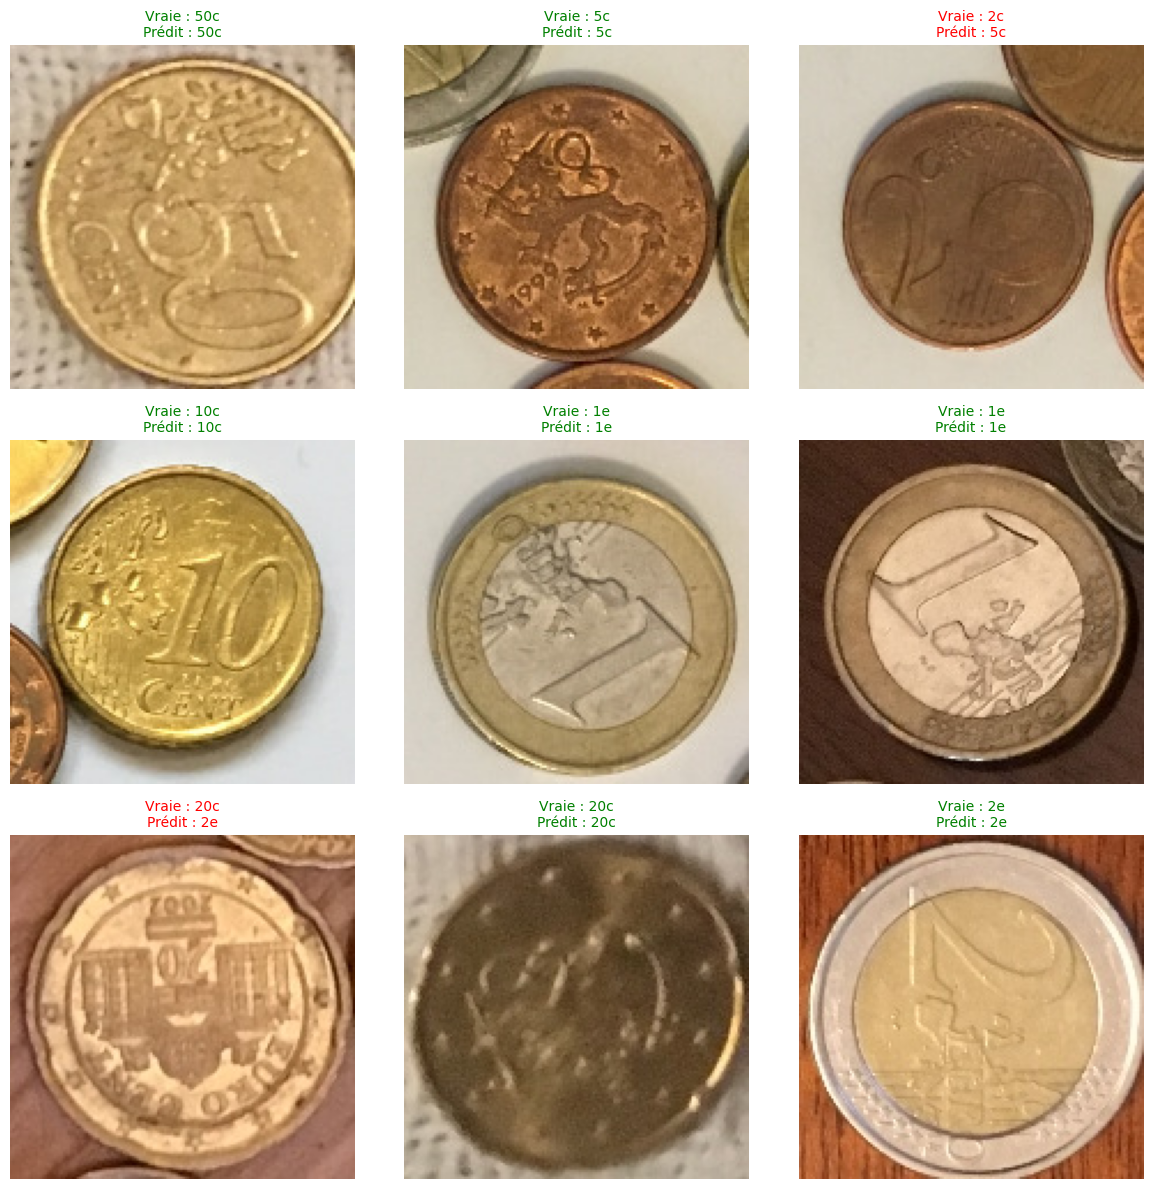

In [ ]:
# Récupérer les labels prédits et réels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Récupérer le mapping {index: label}
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}  # inverse du dictionnaire

# Choisir des indices aléatoires
random_indices = random.sample(range(len(y_true)), 9)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(random_indices):
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = plt.imread(img_path)

    # Vraie et prédite
    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[y_pred[idx]]

    # Affichage
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Vraie : {int_to_class[int(true_label)]}\nPrédit : {int_to_class[int(pred_label)]}",
        color="green" if true_label == pred_label else "red",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
predictions[0]



array([9.6808030e-08, 9.2940378e-01, 3.5665074e-08, 2.5465694e-08,
       2.2918122e-05, 3.0060642e-07, 1.8780548e-09, 7.0572838e-02],
      dtype=float32)

In [ ]:


# Indices des classes prédites (0 à 7)
predicted_classes = np.argmax(predictions, axis=1)


In [ ]:


# Convertir les indices en noms de classes
predicted_labels = [int_to_class[i] for i in predicted_classes]


In [ ]:
df_test['predicted_labels'] = predicted_labels
df_test.head()


filename labels predicted_labels
0  1c/test_19_37.jpg      1               1c
1  1c/test_21_35.jpg      1               1c
2   1c/test_5_25.jpg      1               1c
3   1c/test_7_19.jpg      1               1c
4   1c/test_6_15.jpg      1               1c

**Récupérer les vraies classes et les prédictions**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Indices des classes réelles (y_true)
y_true = test_generator.classes  # entiers 0 à 7

# Indices des classes prédites (y_pred)
y_pred = np.argmax(predictions, axis=1)


## **7.5 Analyse des métriques et courbes clés**

### **7.5.1 Calculer la précision globale**

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"Précision globale sur le test set : {acc:.4f}")


Précision globale sur le test set : 0.7070


### **7.5.2 Matrice de confusion**

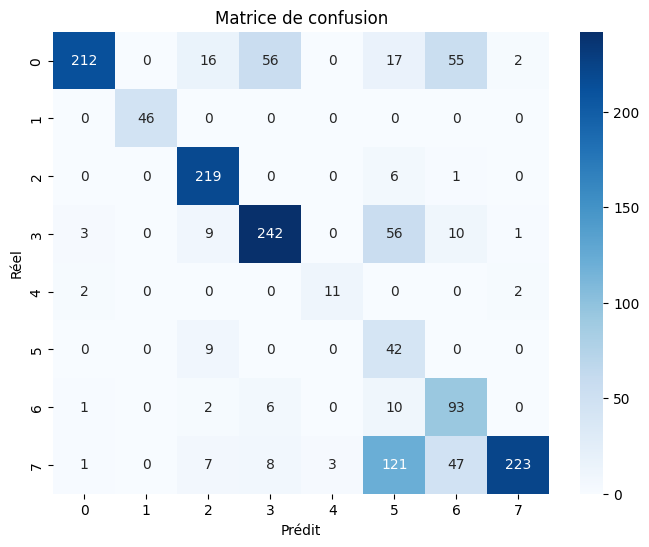

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


### **7.5.3 Calcul de la précision par classe**

/tmp/ipython-input-1642583709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_accuracy, palette="viridis")


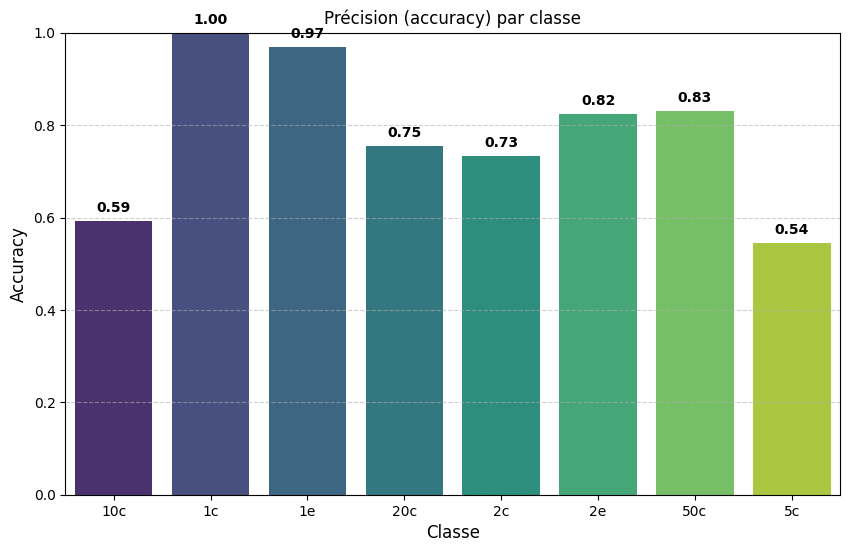

In [ ]:

class_labels = [int_to_class[int(x)] for x in list(test_generator.class_indices.keys())]

# accuracy_i = (nombre de bonnes prédictions pour cette classe) / (nombre total d'images de cette classe)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# 🔹 4. Affichage
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_accuracy, palette="viridis")

plt.title("Précision (accuracy) par classe", fontsize=12)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les valeurs au-dessus des barres
for i, v in enumerate(class_accuracy):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

### **7.5.4 Rapport de classification**

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.59      0.73       358
           1       1.00      1.00      1.00        46
           2       0.84      0.97      0.90       226
           3       0.78      0.75      0.76       321
           4       0.79      0.73      0.76        15
           5       0.17      0.82      0.28        51
           6       0.45      0.83      0.58       112
           7       0.98      0.54      0.70       410

    accuracy                           0.71      1539
   macro avg       0.75      0.78      0.71      1539
weighted avg       0.85      0.71      0.74      1539



# **8. Déploiement**

* Intégration dans une interface (Streamlit).
[Github](https://github.com/Darryll1/EuroMoneyAI/blob/main/app.py)

* Déploiement sur le cloud (Streamlit Cloud).
[Streamlit Cloud](https://b5bl9ws57rkpbkwq6dqwtz.streamlit.app/)



# **9. Suivi & Maintenance**





## **9.1 Surveiller les performances en production en mettrant en place un monitoring (MLflow).**

In [ ]:
# Configurer MLflow
mlflow.set_experiment("piece_euro_prediction")

def log_prediction_metrics(model, X, y_true, step="production"):
    # Prévisions
    y_pred = np.argmax(model.predict(X), axis=1)
    accuracy = np.mean(y_pred == y_true)

    # Logger dans MLflow
    with mlflow.start_run(run_name=f"prediction_{step}"):
        mlflow.log_param("detection_piece_euro", "best_model5_final.keras")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.tensorflow.log_model(model, artifact_path="model")

    print(f"[MLflow] Accuracy enregistrée: {accuracy*100:.2f}%")
    return accuracy





In [ ]:
# Créer un DataFrame vide pour stocker toutes les images
df_prods = pd.DataFrame(columns=['filename', 'labels'])

# Boucle sur les labels et leurs codes encodés
for label, code in zip(labels, encoded_labels):
    folder_path = os.path.join(prod_dir, label)
    images = os.listdir(folder_path)
    print(f"Il y a {len(images)} images pour la classe {label}")

    # Ajouter le chemin relatif dans filename : "classe/nom_fichier"
    file_paths = [os.path.join(label, img) for img in images]

    # Créer le DataFrame pour cette classe
    df_label = pd.DataFrame({
        'filename': file_paths,
        'labels': code
    })

    # Concaténer avec le DataFrame principal
    df_prods = pd.concat([df_prods, df_label], ignore_index=True)



# Nombre d'images
print(f"Total images : {len(df_prods)}")
print(df_prods.head())


Il y a 46 images pour la classe 1c
Il y a 15 images pour la classe 2c
Il y a 410 images pour la classe 5c
Il y a 358 images pour la classe 10c
Il y a 321 images pour la classe 20c
Il y a 112 images pour la classe 50c
Il y a 226 images pour la classe 1e
Il y a 51 images pour la classe 2e
Total images : 1539
            filename labels
0  1c/test_19_37.jpg      1
1  1c/test_21_35.jpg      1
2   1c/test_5_25.jpg      1
3   1c/test_7_19.jpg      1
4   1c/test_6_15.jpg      1


In [ ]:
# Split stratifié pour que chaque classe soit représentée dans train et val car notre dataframe a les classes groupé l'une après l'autre
df_prod, df_new = train_test_split(
    df_prods,
    test_size=0.3,
    stratify=df_prods['labels'],
    random_state=42
)

/tmp/ipython-input-1186461906.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts.values, palette="viridis", edgecolor=".2")


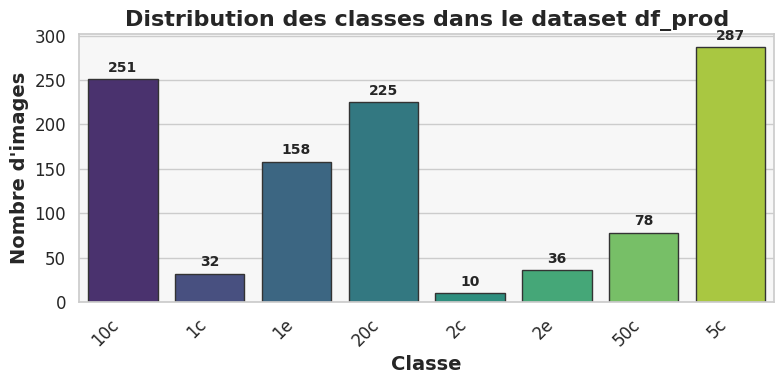

In [ ]:

# Créer un mapping int → nom de classe
label_mapping = dict(zip(encoder_target.transform(labels), labels))

# Compter le nombre d'images par label encodé
class_counts = df_prod['labels'].value_counts().sort_index()

# Remplacer les codes par les noms de classes
class_names = [label_mapping[i] for i in class_counts.index]

# Style Seaborn moderne
sns.set(style="whitegrid", palette="pastel")

# Figure plus grande pour la lisibilité
plt.figure(figsize=(8,4))

# Barplot avec couleurs et edge
sns.barplot(x=class_names, y=class_counts.values, palette="viridis", edgecolor=".2")

# Ajouter des valeurs au-dessus des barres
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Rotation des labels pour éviter le chevauchement
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Titres et labels plus visibles
plt.xlabel("Classe", fontsize=14, fontweight='bold')
plt.ylabel("Nombre d'images", fontsize=14, fontweight='bold')
plt.title("Distribution des classes dans le dataset df_prod", fontsize=16, fontweight='bold')

# Ajout d'un fond clair
plt.gca().set_facecolor('#f7f7f7')

plt.tight_layout()
plt.show()


In [ ]:
df_prod['labels'] = df_prod['labels'].astype(str)

# Générateur pour les données de test
prod_datagen = ImageDataGenerator(rescale=1./255)

prod_generator = prod_datagen.flow_from_dataframe(
    df_prod,
    directory= prod_dir,
    x_col='filename',
    y_col='labels',
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical',
    shuffle=False  # Ne pas mélanger les données de test
)


Found 1077 validated image filenames belonging to 8 classes.


In [ ]:
best_model = tf.keras.models.load_model(f"{save_dir}/best_model5_trial_6.keras")

In [ ]:
# Récupérer toutes les images et labels du générateur
X_prod, y_prod = [], []

for i in range(len(prod_generator)):
    X_batch, y_batch = prod_generator[i]
    X_prod.append(X_batch)
    y_prod.append(y_batch)

# Convertir en tableaux numpy
X_prod = np.vstack(X_prod)  # concaténer toutes les images
y_prod = np.argmax(np.vstack(y_prod), axis=1)  # convertir one-hot en labels

# Logger les métriques avec MLflow
accuracy = log_prediction_metrics(best_model, X_prod, y_prod, step="production")


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step


2025/10/13 22:16:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 22:16:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/13 22:16:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[MLflow] Accuracy enregistrée: 71.68%


## **9.2 Détection de data drift**

**data drift**, c’est-à-dire les changements dans la distribution des données entre un jeu de données de référence (historique) et un nouveau jeu de données (production ou test).

In [ ]:
def check_label_drift(df_ref, df_new):
    """
    Vérifie la distribution des labels entre df_ref et df_new
    """
    # Convertir labels en str pour éviter le TypeError
    df_ref['labels'] = df_ref['labels'].astype(str)
    df_new['labels'] = df_new['labels'].astype(str)

    counts_ref = df_ref['labels'].value_counts().sort_index()
    counts_new = df_new['labels'].value_counts().sort_index()

    drift_df = pd.DataFrame({
        'Référence': counts_ref,
        'Nouveau': counts_new
    }).fillna(0)

    print(drift_df)

    # Visualisation
    drift_df.plot(kind='bar', figsize=(10,5))
    plt.title("Distribution des labels : référence vs nouveau dataset")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()


        Référence  Nouveau
labels                    
0             254      107
1              77       14
2             248       68
3             227       96
4              25        5
5              45       15
6             131       34
7             284      123


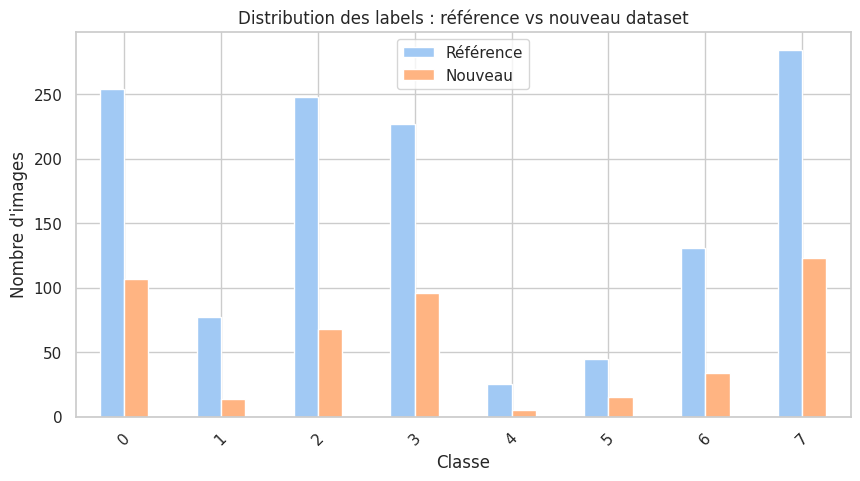

In [ ]:
check_label_drift(df_train,df_new)

## **9.3 Réentraînement automatique (nouvelles données)**



In [ ]:
best_parameters

{'rotation_range': 0,
 'width_shift_range': 0.29357827184211027,
 'height_shift_range': 0.017525532847754346,
 'zoom_range': 8.025368755599344e-05,
 'horizontal_flip': False,
 'learning_rate': 0.00015544568253926652,
 'dropout_rate': 0.3183658163946006,
 'dense_units': 256,
 'optimizer': 'adam'}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def retrain_model(new_data_dir, old_model_path, save_dir, epochs=10, batch_size=16):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Augmentation simple pour fine-tuning
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=best_parameters['rotation_range'],
        width_shift_range= best_parameters['width_shift_range'],
        height_shift_range=best_parameters['height_shift_range'],
        zoom_range=best_parameters['zoom_range'],
        horizontal_flip=best_parameters['horizontal_flip'],
        fill_mode='nearest'
    )

    new_train_gen = datagen.flow_from_dataframe(
        new_data_dir,
        test_dir,
        x_col='filename',
        y_col='labels',
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Charger le modèle existant
    model = load_model(old_model_path)

    # Callbacks
    early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2)


    # Fine-tuning
    model.fit(
        new_train_gen,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    model_path = os.path.join(save_dir, "best_model_retrained.keras")
    model.save(model_path)
    print(f"[Retrain] Nouveau modèle sauvegardé : {model_path}")
    return model

In [ ]:
retrain_model(df_new,save_dir+"/best_model5_trial_6.keras",save_dir)

Found 462 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7303 - loss: 1.2832 - learning_rate: 7.7723e-05
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8438 - loss: 0.4340 - learning_rate: 7.7723e-05
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.8612 - loss: 0.3340 - learning_rate: 7.7723e-05
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9281 - loss: 0.2582 - learning_rate: 7.7723e-05
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9608 - loss: 0.1357 - learning_rate: 7.7723e-05
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9322 - loss: 0.1438 - learning_rate: 7.7723e-05
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9728 - loss: 0.0793 - learning_rate: 7.7723e-05
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9631 - loss: 0.1008 - learning_rate: 7.7723e-05
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9869 - loss: 0.0446 - l

<Sequential name=sequential, built=True>